# Letter Detection

Plan
0. load image
1. preprocessing
  - determine letter boundary
  - letter rotation
2. train, validation, and test datasets
  - save final postprocessed images to folders
  - create train and validation and test sets:
    - augmentation of letters + bubbles
    - TODO: vary the alpha parameter
  - create dataloaders
3. CNN models
  - create CNN structure

In [1]:
import requests
import os
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import rotate

from collections import Counter
from tqdm.auto import tqdm
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torchvision import transforms

from PIL import Image, ImageDraw, ImageFont
import cv2
import random

import string

Mounted at /content/drive


In [13]:
transform_to_tensor = transforms.Compose([transforms.ToTensor()])

alphabet = list(string.ascii_uppercase)
label_to_idx = {l: i for i, l in enumerate(alphabet)}
idx_to_label = {v: k for k, v in label_to_idx.items()}

In [ ]:
# root = os.path.abspath(os.listdir('./drive/MyDrive/deep_learning_letters')[0])

In [2]:
root = './drive/MyDrive/deep_learning_letters'
os.listdir(root)

['letter_detection.ipynb',
 'pictures_to_predict',
 'train',
 'valid',
 'models',
 'Copy of letter_detection.ipynb']

In [3]:
def fix_seed(seed: int = 42) -> None:
    """
    Set seeds for reproducibility
    :param seed: seed value
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_seed(101)

## 0. Load image

In [ ]:
### Read in the image

In [ ]:
image_url = 'http://158.160.26.174/leters_1.png'
image_name = 'letters_1.jpg'
if image_name in os.listdir('.'):
    pass
else:
    img_data = requests.get(image_url).content
    with open(image_name, 'wb') as handler:
        handler.write(img_data)

In [ ]:
Image.MAX_IMAGE_PIXELS = 1900000000

im_frame = Image.open(image_name)

In [ ]:
np_img = np.asarray(im_frame)

In [ ]:
np_img.shape

(30000, 30000, 3)

## 1. **Preprocessing**

### 1.1 Letter boundary

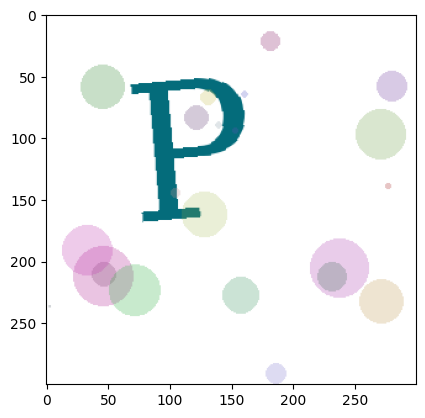

In [ ]:
def image_range(image: np.array, row_start: int, col_start: int, box: int):
  a = image[row_start:row_start + box, col_start:col_start+box, :]
  return a

letter_range_img = image_range(np_img, 0, 300, 300)
plt.imshow(letter_range_img)
plt.show()

In [ ]:
(np_img.shape[0] / 300) * (np_img.shape[1] / 300)

10000.0

Letter boundary -> 300 by 300
Therefore we have $(30,000 / 300)^2 = 10,000$ letters

In [ ]:
LETTER_BOX = 300

### 1.2 Rotations

(300, 300, 3)


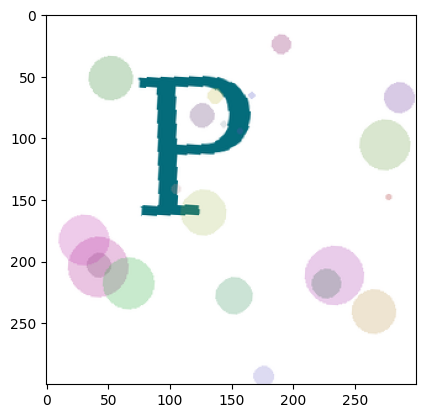

In [ ]:
def image_range_rotate(image: np.array, row_start: int, col_start: int, box: int, degree_rot: float):
  a = image[row_start:row_start + box, col_start:col_start+box, :]
  max_a = a.max()
  rot_a = rotate(a, angle=degree_rot, cval=255)
  
  horiz_diff = int((rot_a.shape[0] - a.shape[0]) / 2)
  vert_diff = int((rot_a.shape[1] - a.shape[1]) / 2)

  rot_a_cropped = rot_a[0 + horiz_diff: rot_a.shape[0] - horiz_diff,
                        0 + vert_diff: rot_a.shape[1] - vert_diff, :]
  
  return rot_a_cropped

rot_img = image_range_rotate(np_img, 0, 300, 300, -4)
print(rot_img.shape)
plt.imshow(rot_img)
plt.show()

In [ ]:
def rotate_image(image: np.array, degree_rot: float):
  rot_img = rotate(image, angle=degree_rot)
  
  horiz_diff = int((rot_img.shape[0] - image.shape[0]) / 2)
  vert_diff = int((rot_img.shape[1] - image.shape[1]) / 2)

  rot_a_cropped = rot_img[0 + horiz_diff: rot_img.shape[0] - horiz_diff,
                          0 + vert_diff: rot_img.shape[1] - vert_diff].astype(float)
  
  return rot_a_cropped

In the first row we start with letter H in perfect position. By the end a letter make one full revolution + some rotation. By visual inspection we an clearly observe that letter T is in the "perfect" rotated position (90 degree to the left). It's index in the first row is 90

255


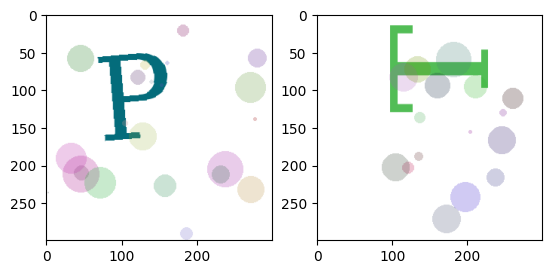

In [ ]:
fig, axs = plt.subplots(1, 2)

first = 0
second = 90

letter_range_img_0 = image_range(np_img, 0, 0 + LETTER_BOX * first, LETTER_BOX)
axs[0].imshow(letter_range_img)
letter_range_img_n = image_range(np_img, 0, 0 + LETTER_BOX * second, LETTER_BOX)
axs[1].imshow(letter_range_img_n)

print(letter_range_img_0.max())

plt.show()

We claim that in 90 "moves" a letter does 360 + 90 rotation. Thus every "move" a letter / picture of a letter does 450 / 90 = 5 degree rotation

255


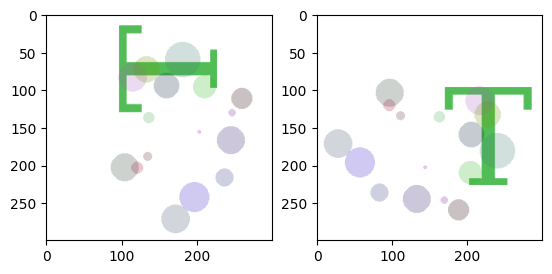

In [ ]:
fig, axs = plt.subplots(1, 2)

letter_num = 90

letter_og = image_range(np_img, 0, 0 + LETTER_BOX * letter_num, LETTER_BOX)
axs[0].imshow(letter_og)
letter_unrotated = image_range_rotate(np_img, 0, 0 + LETTER_BOX * letter_num, LETTER_BOX, -letter_num * 5)
axs[1].imshow(letter_unrotated)

print(letter_unrotated.max())

plt.show()

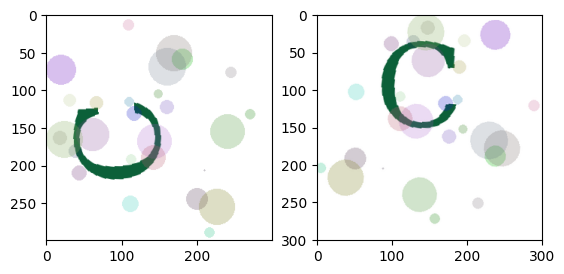

In [ ]:
fig, axs = plt.subplots(1, 2)

letter_num_row = 78
letter_num_col = 13

letter_og = image_range(np_img, letter_num_row * LETTER_BOX, 
                        LETTER_BOX * letter_num_col, 
                        LETTER_BOX)
axs[0].imshow(letter_og)
letter_unrotated = image_range_rotate(np_img, letter_num_row * LETTER_BOX, 
                                      LETTER_BOX * letter_num_col, 
                                      LETTER_BOX, 
                                      -(letter_num_col + letter_num_row) * 5)
axs[1].imshow(letter_unrotated)


plt.show()

In [ ]:
letter_og.shape

(300, 300, 3)

## 2. Train, validation and test datasets

### 2.1 Postprocessed images to files

In [ ]:
root

'./drive/MyDrive/deep_learning_letters'

In [ ]:
IMAGES_TO_PREDICT_PATH = Path(root + '/pictures_to_predict')
IMAGES_TO_PREDICT_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
os.listdir(str(root))

['letter_detection.ipynb', 'pictures_to_predict']

In [ ]:
def generate_image_folder_dataset(big_image: np.ndarray, 
                                  save_folder: Path) -> None:
    rows = int(big_image.shape[0] / LETTER_BOX)
    cols = int(big_image.shape[1] / LETTER_BOX)
    
    i = 0
    for row in tqdm(range(rows)):
        for col in range(cols):
          file_name = Path(save_folder, f"{i}.png")

          rotation = -(row + col) * 5
          np_img_let_rot = image_range_rotate(np_img, 
                                              row * LETTER_BOX, 
                                              LETTER_BOX * col, 
                                              LETTER_BOX, 
                                              rotation)

          im = Image.fromarray(np_img_let_rot).convert("RGB")
          im.save(str(file_name))

          i += 1

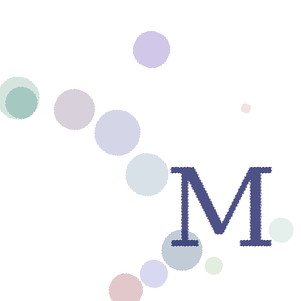

In [ ]:
row = 10
col = 40
rotation = -(row + col) * 5
np_img_let_rot = image_range_rotate(np_img, 
                                    row * LETTER_BOX, 
                                    LETTER_BOX * col, 
                                    LETTER_BOX, 
                                    rotation)

im = Image.fromarray(np_img_let_rot).convert("RGB")
im.show()

In [ ]:
generate_image_folder_dataset(np_img, IMAGES_TO_PREDICT_PATH)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import gc 
gc.collect()

18273

In [ ]:
import ctypes
libc = ctypes.CDLL("libc.so.6") # clearing cache 
libc.malloc_trim(0)

1

### 2.2 Train, validation, test datasets
- first, generate 26 * N training pictures with different fonts
- create dataloader for train and validation

In [ ]:
font_list = [ 
    '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf',
    '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf',
    '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf',
    '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf',
    '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf',
    '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf',
 ]

In [ ]:
# !pip show pandas

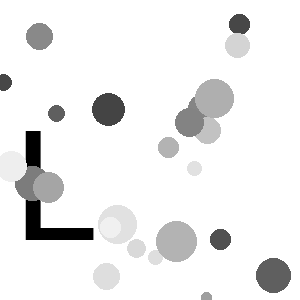

In [ ]:
# playing around

font = ImageFont.truetype(font_list[2], 150)  # make random
num_circles = 25
text_sample = 'L'  # input

bgcolor = 'white'  # given
txtcolor = 'black'  # given
text_width, text_height = (300, 300)  # (w,h) changes the size of the white box surrounding the string

text_sample_img = Image.new("RGBA", (text_width, text_height), bgcolor)
draw = ImageDraw.Draw(text_sample_img)
draw.text((10, 100), text_sample, txtcolor, font=font) 

start_x, start_y = 0, 0

ys = random.sample(range(300), num_circles)
xs = random.sample(range(300), num_circles)

circ_cols = [colors['black'].value()]

for num_circ in range(num_circles):
  
  overlay_color = random.choice(circ_cols)
  size = random.randint(5, 20)
  transparency = random.randint(5, 80) / 100  # Degree of transparency, 0-100%
  opacity = int(255 * transparency)
  # overlay = Image.new('RGBA', (text_width, text_height), overlay_color+(0,))
  # overlay_draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
  llx = xs[num_circ] - size
  lly = ys[num_circ] - size
  urx = xs[num_circ] + size
  ury = ys[num_circ] + size

  draw.ellipse(((llx, lly), (urx, ury)), fill=overlay_color+(opacity,))

# img = text_sample_img.rotate(5)
img_np = np.array(text_sample_img.convert('RGB'))
text_sample_img.show()

In [ ]:

def generate_text_augmentation(letter: str, 
                               font: str, 
                               font_size: int,
                               num_circles: int, 
                              #  rotation: int, 
                               background_colors: list,
                               letter_color: tuple,
                               loc_circ_xs: list,
                               loc_circ_ys: list,
                               circ_sizes: list,
                               loc: tuple,
                               alpha: float) -> Image:
  bgcolor = 'white'  # given
  text_width, text_height = (300, 300)

  font = ImageFont.truetype(font, font_size)

  foreground_img = Image.new("RGB", (text_width, text_height), bgcolor)
  draw = ImageDraw.Draw(foreground_img)
  draw.text(loc, letter, fill=letter_color, font=font) 
  # draw.line((0, 0.95*font_size) + (im.width, 0.95*font_size), fill=128)
  # draw.line((0, 0.2*font_size) + (im.width, 0.2*font_size), fill=128)
  # draw.line((font_size, 0) + (font_size, im.width), fill=128)
  # foreground_img = foreground_img.rotate(rotation, fillcolor = (255, 255, 255))
  
  background_img = Image.new("RGB", (text_width, text_height), bgcolor)
  draw = ImageDraw.Draw(background_img)
  for num_circ in range(num_circles):
    size = circ_sizes[num_circ]
    llx = loc_circ_xs[num_circ] - size
    lly = loc_circ_ys[num_circ] - size
    urx = loc_circ_xs[num_circ] + size
    ury = loc_circ_ys[num_circ] + size
    
    background_color = background_colors[num_circ]
    draw.ellipse(((llx, lly), (urx, ury)), fill=background_color)

  height, width = background_img.height, background_img.width
  foreground = np.array(foreground_img)
  background = np.array(background_img)
  for y in range(height):
      for x in range(width):
          overlay_color = foreground[y, x]  # first three elements are color (RGB)
          overlay_alpha = alpha  # 4th element is the alpha channel, convert from 0-255 to 0.0-1.0

          # get the color from the background image
          background_color = background[y, x]

          # combine the background color and the overlay color weighted by alpha
          composite_color = background_color * (1 - overlay_alpha) + overlay_color * overlay_alpha

          # update the background image in place
          foreground[y, x] = composite_color
  
  img = Image.fromarray(foreground).convert("RGB")
  
  return img

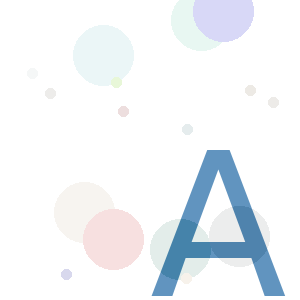

300 300


In [ ]:
font = font_list[3]
font_size = 200
colors_use = [colors[col].value() for col in list(colors.keys()) if '3' in col or '4' in col]
random.seed(1000)

num_circles = 17
alpha = 0.85
xs = random.sample(range(300), num_circles)
ys = random.sample(range(300), num_circles)
sizes = random.choices((5, 30), k=num_circles)
true_font_size = int(font_size 
                     * 0.75)
d = int(true_font_size * np.sqrt(2))
r = int(d / 2)
# x_text, y_text = random.sample(range(true_font_size - r, 300 - d), 2)
x_text, y_text = random.sample(range(5, 300 - true_font_size), 2)
loc = (x_text, y_text - font_size*0.2)
loc = (300 - true_font_size, 300 - true_font_size- font_size*0.2)
# loc = (300 - 1.5* r, 300 - 1.5*r - font_size*0.2)

img = generate_text_augmentation('A', font, font_size, num_circles, colors_use, 
                                 colors['steelblue'], xs, ys, sizes, loc, alpha)
img.show()
print(img.height, img.width)

In [ ]:
loc

(150, 110.0)

In [ ]:
# TRAIN_PATH = Path('./train')
# TRAIN_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
font_sizes = np.arange(100, 200, 10)
colors_use = [colors[col].value() for col in list(colors.keys()) if '3' in col or '4' in col]
main_colors = ['blue', 'steelblue', 'black', 'green', 'purple', 'maroon', 'orange']
nums_circles = np.arange(10, 40, 5)
text_pos_times = 5

In [ ]:
per_letter = len(font_sizes) * len(nums_circles) * len(font_list) * text_pos_times

In [ ]:
alphabet = list(string.ascii_uppercase)
alphabet.index("I")
per_letter

1800

In [ ]:
root

'./drive/MyDrive/deep_learning_letters'

In [ ]:
def generate_train_images(train: bool=True):
  if train:
    img_save_path = root + '/train'
  else:
    img_save_path = root + '/valid'

  alphabet = list(string.ascii_uppercase)
  images_counter = Counter()

  files = []
  labels = []

  font_sizes = np.arange(100, 200, 10)
  colors_use = [colors[col].value() for col in list(colors.keys()) if '3' in col or '4' in col]
  main_colors = ['blue', 'steelblue', 'black', 'green', 'purple', 'maroon', 'orange', 
                'wheat4', 'brown', 'lightcyan4']
  nums_circles = np.arange(10, 40, 5)
  text_pos_times = 3
  alpha_range = range(75, 90)
  sizes_range = range(2, 20)
  loc_range = range(300)
  # rotations = np.arange(0, 720, 5)

  i = 0  #(alphabet.index("I") + 1) * per_letter  # temp fix - crashed
  for letter in tqdm(alphabet):
      class_folder = Path(img_save_path, letter)
      class_folder.mkdir(parents=True, exist_ok=True)

      for font_size in font_sizes:
          for num_circles in nums_circles: 
            for font_style in font_list:
              for pos in range(text_pos_times):
                random.seed(i)

                font_style = random.choice(font_list)
                # font_size = random.choice(font_sizes)
                # num_circles = random.choice(nums_circles)
                main_color = colors[random.choice(main_colors)].value()

                xs = random.sample(loc_range, num_circles)
                ys = random.sample(loc_range, num_circles)

                alpha = random.choice(alpha_range) / 100
                sizes = random.choices(sizes_range, k=num_circles)
                true_font_size = int(font_size * 0.75)
                # d = int(true_font_size * np.sqrt(2))
                # r = int(d / 2)

                x_text, y_text = random.sample(range(5, 295 - true_font_size), 2)
                loc = (x_text, y_text - font_size * 0.2)

                cols_use_temp = colors_use[:num_circles]

                image = generate_text_augmentation(letter, 
                                                   font_style, 
                                                   font_size, 
                                                   num_circles, 
                                                   cols_use_temp, 
                                                   main_color, xs, ys, sizes, 
                                                   loc, alpha)

                images_counter[letter] += 1
                file_name = Path(class_folder, str(i) + '.png')

                files.append(letter + str(file_name))
                labels.append(letter)

                # img = np.array(image)  # np transpose [2, 0, 1]

                # im = Image.fromarray(img).convert("RGB")
                image.save(str(file_name))

                i += 1

                if i % 50 == 0:
                  print(letter)
                  print(i)
                  image.show()

        # break
  if train:
    save_df_path = Path(img_save_path, 'train.csv')
  else:
    save_df_path = Path(img_save_path, 'valid.csv')
  pd.DataFrame({ "image": files, "label": labels }).to_csv(str(save_df_path), index=False)

  # generate_image_folder_dataset(TRAIN_PATH, font_list, colors)

In [ ]:
generate_train_images()

Output hidden; open in https://colab.research.google.com to view.

  0%|          | 0/26 [00:00<?, ?it/s]

B
50


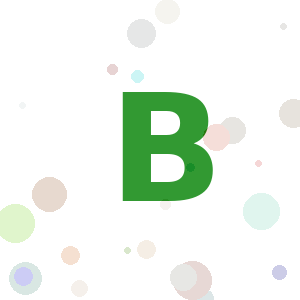

C
100


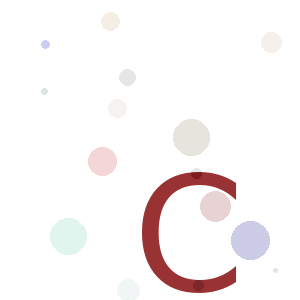

D
150


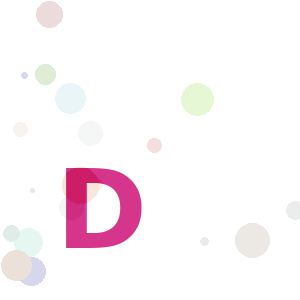

E
200


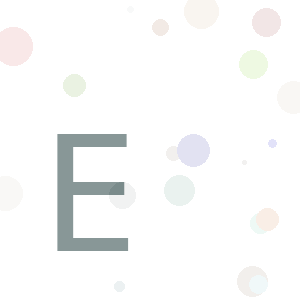

G
250


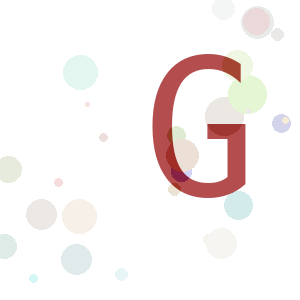

H
300


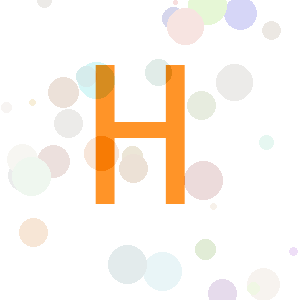

I
350


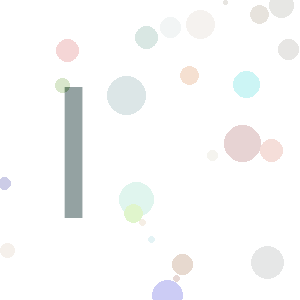

J
400


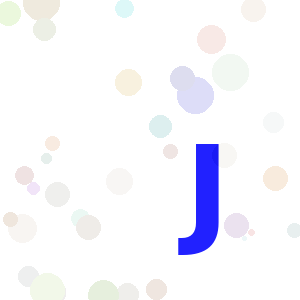

L
450


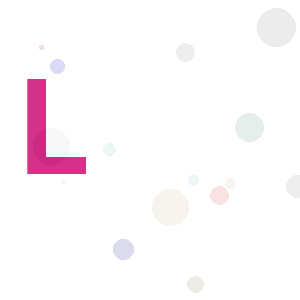

M
500


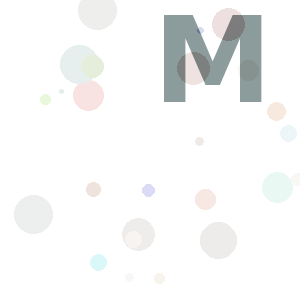

N
550


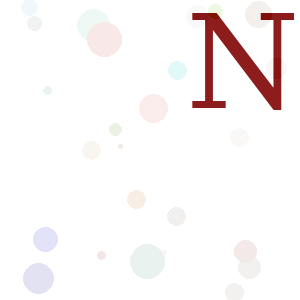

O
600


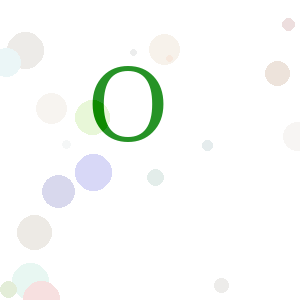

Q
650


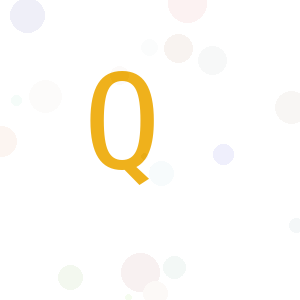

R
700


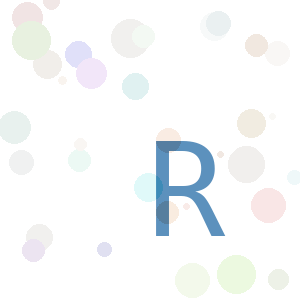

S
750


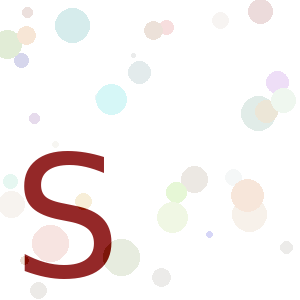

T
800


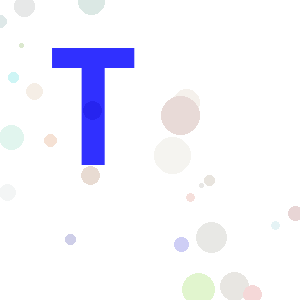

V
850


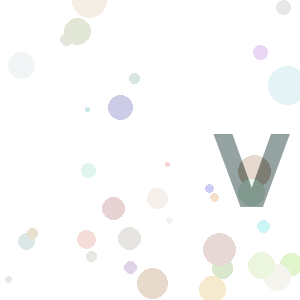

W
900


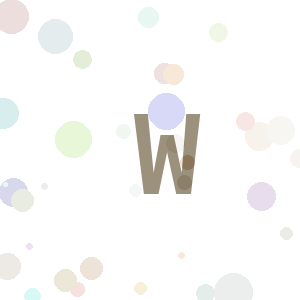

X
950


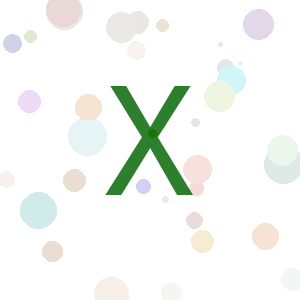

Y
1000


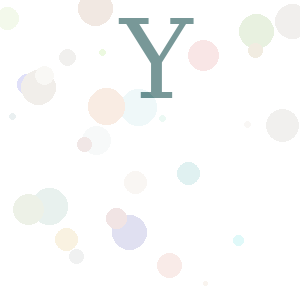

In [ ]:
def generate_valid_images():
  img_save_path = root + '/valid'
  Path(img_save_path).mkdir(parents=True, exist_ok=True)

  alphabet = list(string.ascii_uppercase)
  images_counter = Counter()

  files = []
  labels = []

  font_sizes = np.arange(100, 200, 10)
  colors_use = [colors[col].value() for col in list(colors.keys()) if '3' in col or '4' in col]
  main_colors = ['blue', 'steelblue', 'black', 'green', 'purple', 'maroon', 'orange', 
                'wheat4', 'brown', 'lightcyan4', 'darkgreen', 'cornsilk4', 
                 'deeppink3', 'gainsboro', 'darkgoldenrod2', 'paleturquoise4',]
  nums_circles = np.arange(10, 40, 5)
  alpha_range = range(80, 95)
  # rotations = np.arange(0, 720, 5)

  i = 0
  for letter in tqdm(alphabet):
      class_folder = Path(img_save_path, letter)
      class_folder.mkdir(parents=True, exist_ok=True)

      for num in range(40):
        random.seed(i)

        font_style = random.choice(font_list)
        font_size = random.choice(font_sizes)
        num_circles = random.choice(nums_circles)
        main_color = colors[random.choice(main_colors)].value()

        xs = random.sample(range(300), num_circles)
        ys = random.sample(range(300), num_circles)

        alpha = random.choice(alpha_range) / 100
        sizes = random.choices(range(2, 20), k=num_circles)
        true_font_size = int(font_size * 0.75)

        x_text, y_text = random.sample(range(5, 295 - true_font_size), 2)
        loc = (x_text, y_text - font_size * 0.2)

        cols_use_temp = colors_use[:num_circles]

        image = generate_text_augmentation(letter, 
                                            font_style, 
                                            font_size, 
                                            num_circles, 
                                            cols_use_temp, 
                                            main_color, xs, ys, sizes, 
                                           loc, alpha)

        images_counter[letter] += 1
        file_name = Path(class_folder, str(i) + '.png')

        files.append(letter + str(file_name))
        labels.append(letter)

        # img = np.array(image)  # np transpose [2, 0, 1]

        # im = Image.fromarray(img).convert("RGB")
        image.save(str(file_name))

        i += 1

        if i % 50 == 0:
          print(letter)
          print(i)
          image.show()


  save_df_path = Path(img_save_path, 'valid.csv')
  pd.DataFrame({ "image": files, "label": labels }).to_csv(str(save_df_path), index=False)

generate_valid_images()

### 2.3 DataLoaders

In [ ]:
train_labels_paths = pd.read_csv(str(root + '/train/train.csv'))

In [ ]:
errors = []
for iddx, ppath in tqdm(enumerate(train_labels_paths.image)):
    try:
      img_path = ppath[1:]
      image = Image.open(img_path)
      image = np.array(image)
    except Exception as e:
      print(e)
      print(ppath)
      errors.append([iddx, ppath])

0it [00:00, ?it/s]

[Errno 2] No such file or directory: 'drive/MyDrive/deep_learning_letters/train/O/15334.png'
Odrive/MyDrive/deep_learning_letters/train/O/15334.png
[Errno 2] No such file or directory: 'drive/MyDrive/deep_learning_letters/train/O/15335.png'
Odrive/MyDrive/deep_learning_letters/train/O/15335.png
[Errno 2] No such file or directory: 'drive/MyDrive/deep_learning_letters/train/O/15336.png'
Odrive/MyDrive/deep_learning_letters/train/O/15336.png
[Errno 2] No such file or directory: 'drive/MyDrive/deep_learning_letters/train/T/21215.png'
Tdrive/MyDrive/deep_learning_letters/train/T/21215.png
[Errno 2] No such file or directory: 'drive/MyDrive/deep_learning_letters/train/T/21216.png'
Tdrive/MyDrive/deep_learning_letters/train/T/21216.png


In [ ]:
errors_index = [ei[0] for ei in errors]

In [ ]:
clean_train_labels_paths = train_labels_paths.loc[[idx for idx in train_labels_paths.index if idx not in errors_index]]

In [70]:
# clean_train_labels_paths.to_csv(str(root + '/train/train_clean.csv'), index=False)
clean_train_labels_paths = pd.read_csv(str(root + '/train/train_clean.csv'))

In [ ]:
valid_labels_paths = train_labels_paths = pd.read_csv(str(root + '/valid/valid.csv'))
errors = []
for iddx, ppath in tqdm(enumerate(valid_labels_paths.image)):
    try:
      img_path = ppath[1:]
      image = Image.open(img_path)
      image = np.array(image)
    except Exception as e:
      print(e)
      print(ppath)
      errors.append([iddx, ppath])

errors_index = [ei[0] for ei in errors]
clean_valid_labels_paths = valid_labels_paths.loc[[idx for idx in valid_labels_paths.index if idx not in errors_index]]

0it [00:00, ?it/s]

In [ ]:
clean_valid_labels_paths.to_csv(str(root + '/valid/valid_clean.csv'), index=False)

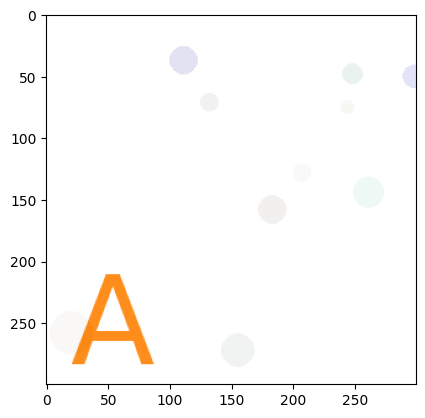

In [71]:
image = cv2.imread(clean_train_labels_paths.iloc[0, 0][1:], 1)
image_cv = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_cv)

In [138]:
image_cv.shape

(300, 300, 3)

In [73]:
np.array(image_cv).min()

19

In [ ]:
# a = cv2.imread(train_labels_paths.iloc[0, 0][1:])
image = Image.open(clean_train_labels_paths.iloc[0, 0][1:])
img = np.array(image)

In [79]:
# all we need to do is define __init__, __len__, and __getitem__

class DatasetLetters(Dataset):
  def __init__(self, root='.', train=True, transform=None, label_2_idx=label_to_idx):
    if train:
      self.p = 'train'
    else:
      self.p = 'valid'

    self.label_to_idx = label_to_idx
    self.root = root
    self.image_labels = pd.read_csv(root + f'/{self.p}' + f'/{self.p}_clean.csv')
    self.transform = transform
  
  def __len__(self):
    return len(self.image_labels)
  
  def __getitem__(self, idx: int) -> dict:
    img_path = os.path.join(self.image_labels.iloc[idx, 0][1:])
    image = Image.open(img_path)
    image = np.array(image)
    label = self.image_labels.iloc[idx, 1]
    label = self.label_to_idx[label]
    if self.transform:
      image = self.transform(image).reshape(-1, 300, 300)
    else:
      image = np.array(image).reshape(-1, 300, 300)
    
    result = {
        'image': image,
        'label': label
    }

    return result

In [76]:
dataset_test = DatasetLetters(root=root, train=True, ) #transform=transform_to_tensor)

idateset = iter(dataset_test)
item = next(idateset)
assert item['image'].shape == (3, 300, 300)

dataset_test = DatasetLetters(root=root, train=False, ) # transform=transform_to_tensor)

idateset = iter(dataset_test)
item = next(idateset)
assert item['image'].shape == (3, 300, 300)

In [78]:
item['image'].max()

255

## 3 Modeling

In [87]:
def plot_history(train_history, val_history, title='loss', root=root):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    path = Path(root, 'models', 'resnet')
    path.mkdir(exist_ok=True, parents=True)
    path = str(Path(path, "trainig_loss.png"))
    plt.savefig(path)

    plt.show()

In [91]:
from torch.utils.tensorboard import SummaryWriter
import torch


class Trainer:
    def __init__(self, model: nn.Module, optimizer,
                 train_dataset: Dataset, val_dataset: Dataset,
                 tboard_log_dir: str = './tboard_logs/', batch_size: int = 128,
                 root: str = root, name: str = 'some'):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.root = root
        self.name = name

        self.device = 'cpu'
        if torch.cuda.is_available():
            print('using GPU')
            self.device = torch.device("cuda:0")
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir)


    def save_checkpoint(self):
        path = Path(self.root, 'models', self.name)
        path.mkdir(exist_ok=True, parents=True)
        path = str(Path(path, "best_checkpoint.pth"))
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer
        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')

        train_losses = []
        train_accs = []
        val_losses_plot = []
        val_accs_plot = []
        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                # print(batch)
                loss, metrics = model.compute_all(batch)
                train_losses.append(loss.item())
                train_accs.append(metrics['acc'])

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in metrics.items():
                    self.log_writer.add_scalar(k + "/train", v, global_step=self.global_step)
                self.global_step += 1
            
            del batch, loss
            torch.cuda.empty_cache()
            gc.collect()

            with torch.no_grad():
                model.eval()
                val_losses = []
                val_accs = []
                for batch in tqdm(val_loader):
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    loss, metrics = model.compute_all(batch)
                    for k, v in metrics.items():
                        self.log_writer.add_scalar(k + '/validation', v, global_step=self.global_step)
                    val_losses.append(loss.item())
                    val_accs.append(metrics['acc'])

                val_loss = np.mean(val_losses)
                val_acc = np.mean(val_accs)
                if val_loss < best_loss:
                    self.save_checkpoint()
                    print(val_loss)
                    best_loss = val_loss
            
            steps = self.train_dataset.image_labels.shape[0] / self.batch_size
            val_losses_plot.append((steps * (epoch + 1), val_loss))
            val_accs_plot.append((steps * (epoch + 1), val_acc))

            plot_history(train_losses, val_losses_plot, title='loss')
            plot_history(train_accs, val_accs_plot, title='accuracy')
            
            print("Epoch: {2}, val loss: {0}, val accuracy: {1}".format(val_loss,val_acc, epoch))

### 3.1 ResNet

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class CustomResNet(nn.Module):
    def __init__(self, block, layers):
        super().__init__()

        alphabet = list(string.ascii_uppercase)
        self.n_classes = len(alphabet)

        # here you can init layers and stack them with nn.Sequential
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.dropout = nn.Dropout(0.2)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(10, stride=1)
        self.fc = nn.Linear(512, self.n_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.dropout(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['image']
        y = batch['label']

        x = x.reshape(-1, 3, 300, 300)#.unsqueeze(1)
        logits = self.forward(x) # [ bs, self.n_classes ]
        assert logits.size() == torch.Size([x.size(0), self.n_classes]), f"logits size is wrong: {logits.size}"
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

using GPU


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

2.9233466386795044


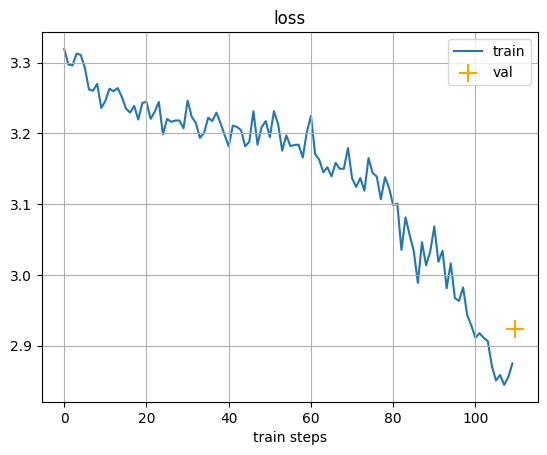

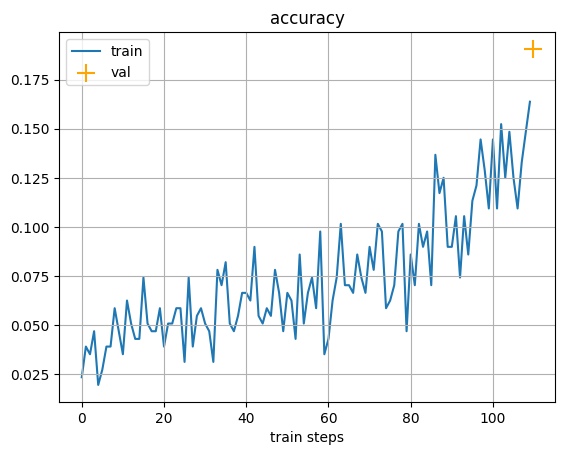

Epoch: 0, val loss: 2.9233466386795044, val accuracy: 0.19062499701976776


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

1.9551785111427307


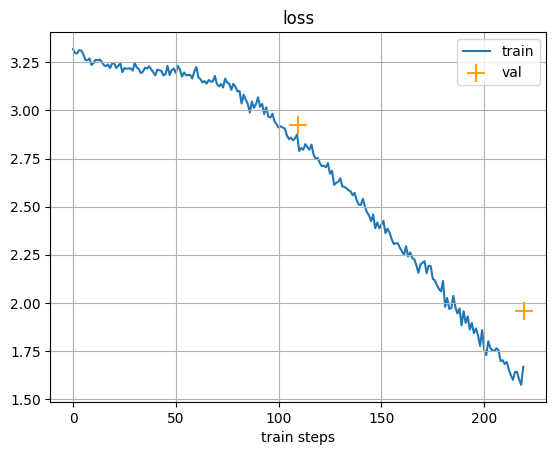

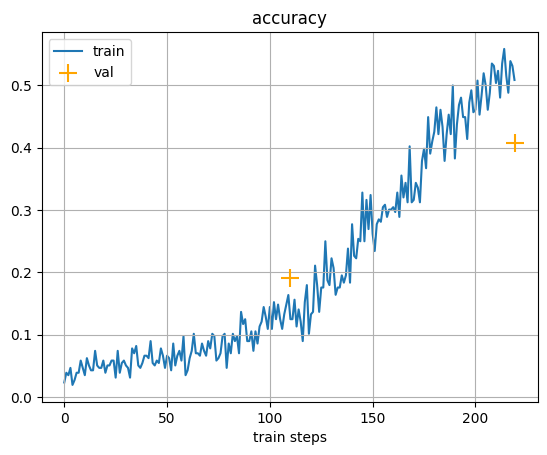

Epoch: 1, val loss: 1.9551785111427307, val accuracy: 0.40703123807907104


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

1.4957407653331756


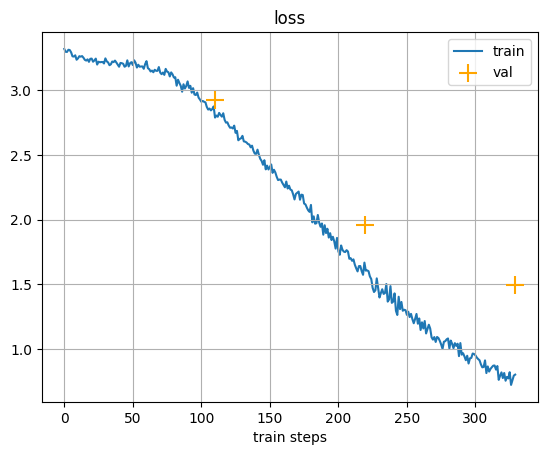

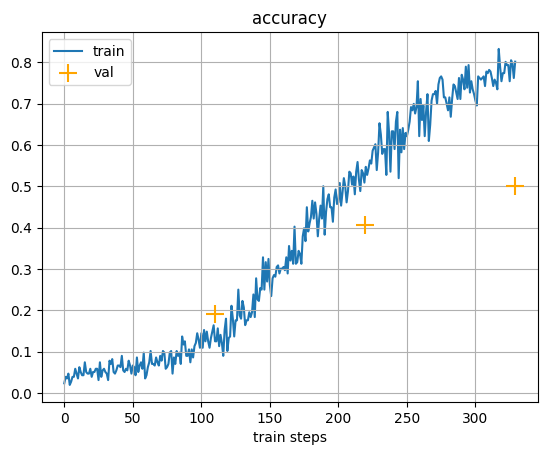

Epoch: 2, val loss: 1.4957407653331756, val accuracy: 0.500781238079071


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0.8622030675411224


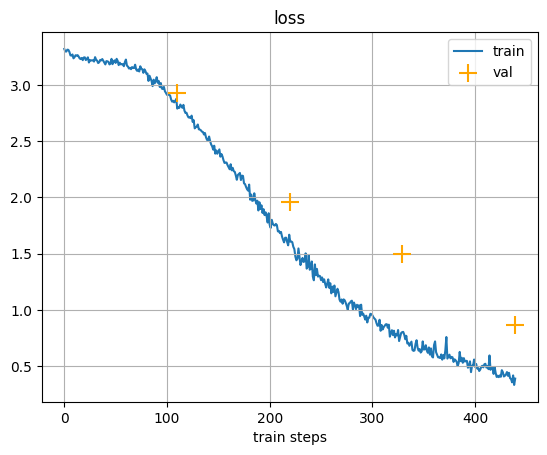

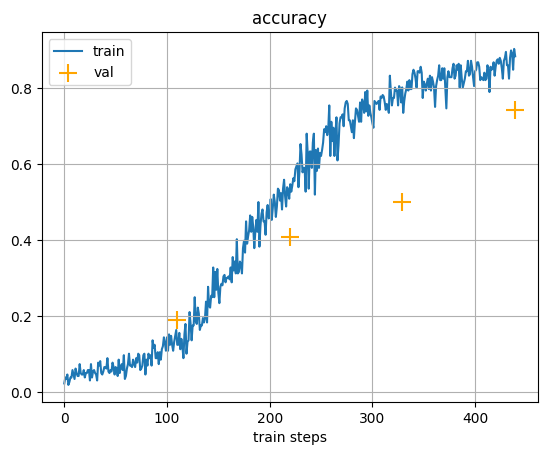

Epoch: 3, val loss: 0.8622030675411224, val accuracy: 0.7406250238418579


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0.5735926374793052


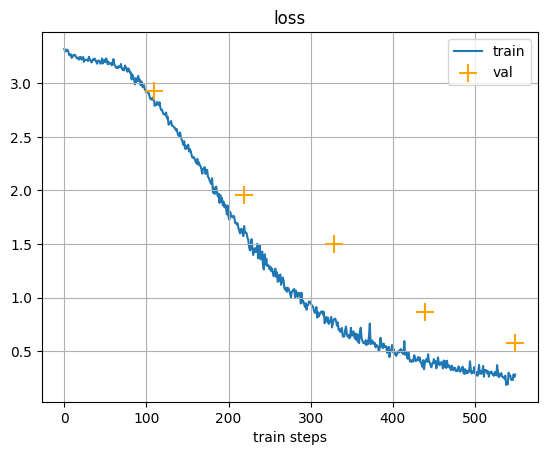

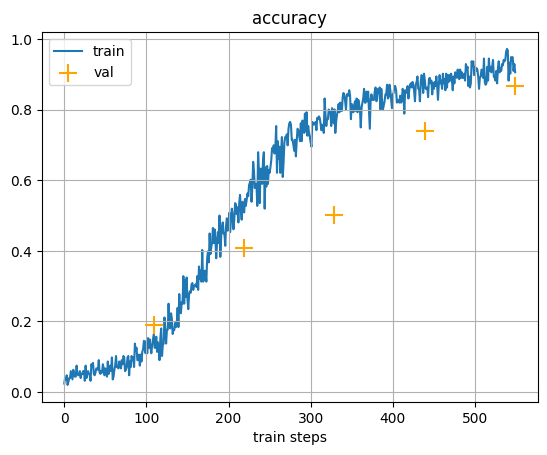

Epoch: 4, val loss: 0.5735926374793052, val accuracy: 0.866406261920929


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0.5094845712184906


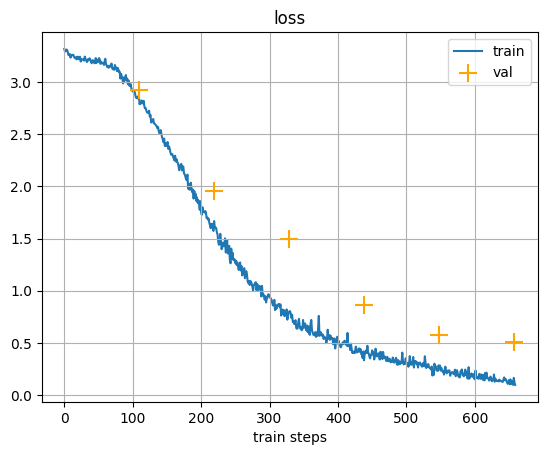

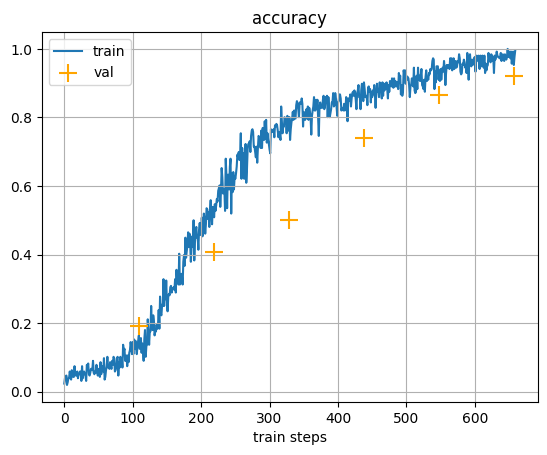

Epoch: 5, val loss: 0.5094845712184906, val accuracy: 0.9195312261581421


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0.37246976867318154


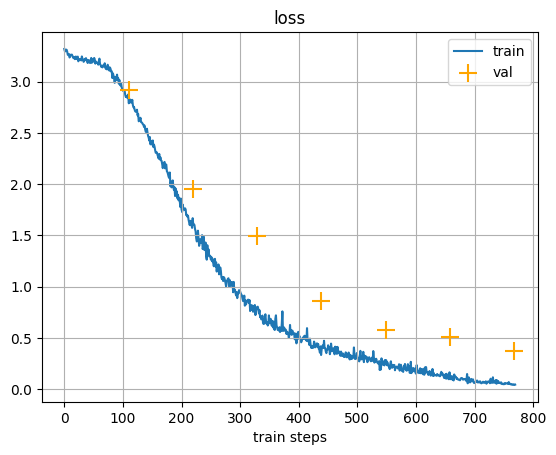

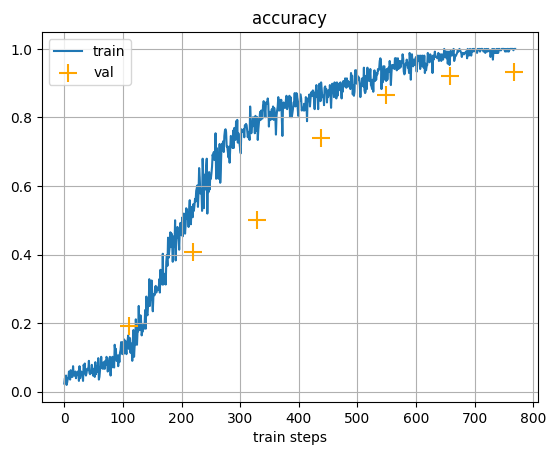

Epoch: 6, val loss: 0.37246976867318154, val accuracy: 0.932812511920929


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0.30696863010525705


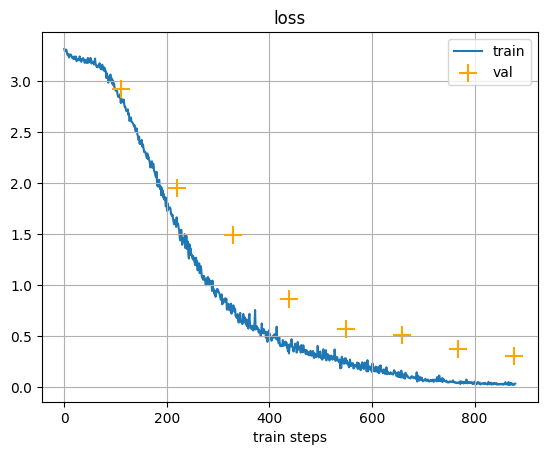

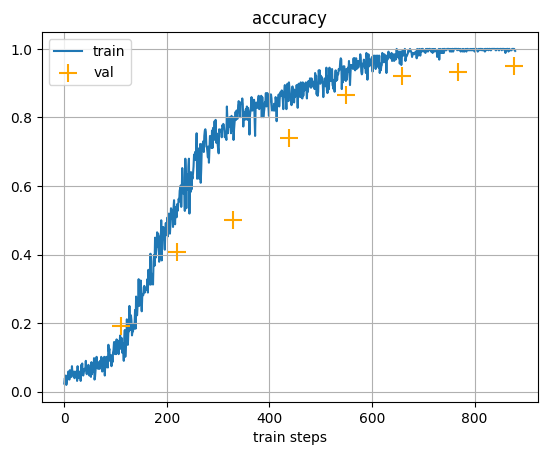

Epoch: 7, val loss: 0.30696863010525705, val accuracy: 0.9507812261581421


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

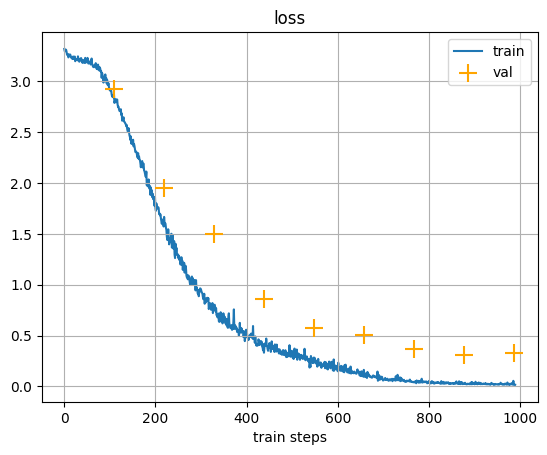

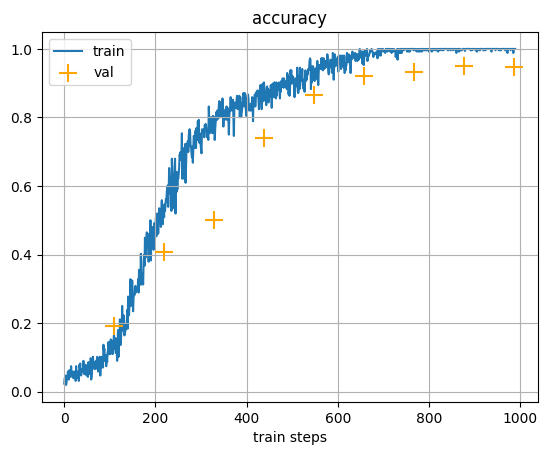

Epoch: 8, val loss: 0.328203459084034, val accuracy: 0.946093738079071


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

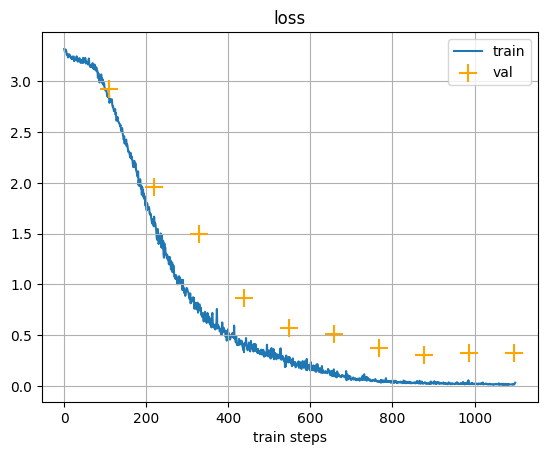

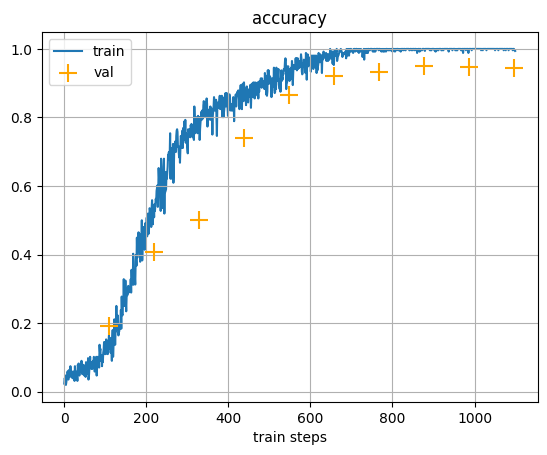

Epoch: 9, val loss: 0.327084069699049, val accuracy: 0.9453125


  0%|          | 0/110 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [111]:
num_epochs = 20
batch_size = 256
learning_rate = 0.001

model = CustomResNet(ResidualBlock, [3, 4, 6, 3])
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9) 

letters_train = DatasetLetters(root=root, train=True, transform=transform_to_tensor)
letters_val = DatasetLetters(root=root, train=False, transform=transform_to_tensor)

trainer = Trainer(model, optimizer, letters_train, letters_val, batch_size=batch_size, 
                  root=root, name='resnet')

fix_seed(101)

trainer.train(100)
save_model = Path(root, 'models', 'resnet')
save_model.mkdir(exist_ok=True, parents=True)
torch.save(model.state_dict(), str(Path(save_model, "custom_resnet.pt"))) # важно сохранить веса обученой модели!

### 3.2 CustomCNN

In [93]:
class CustomVGG(nn.Module):
    def __init__(self,
                 num_pixels_per_img: int = 3*300*300,
                 ):
        super().__init__()

        alphabet = list(string.ascii_uppercase)
        self.n_classes = len(alphabet)

        # here you can init layers and stack them with nn.Sequential
        self.inner = nn.Sequential(
            # [ bs, ch, w, h ]
            nn.Conv2d(3, 8, kernel_size=3, padding=1), # [ bs, 8, w, h ]
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, padding=1), # [ bs, 4, w, h ]
            nn.ReLU(),
            nn.Conv2d(4, 3, kernel_size=3, padding=1), # [ bs, 3, w, h ]
            nn.ReLU(),

            nn.Flatten(1),
            nn.Linear(num_pixels_per_img, self.n_classes),
        )

    def forward(self, x):
        # describe usage of layers here, be careful with input shape
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['image']
        y = batch['label']

        x = x.reshape(-1, 3, 300, 300)#.unsqueeze(1)
        logits = self.inner(x) # [ bs, self.n_classes ]
        assert logits.size() == torch.Size([x.size(0), self.n_classes]), f"logits size is wrong: {logits.size}"
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

using GPU


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

3.264582633972168


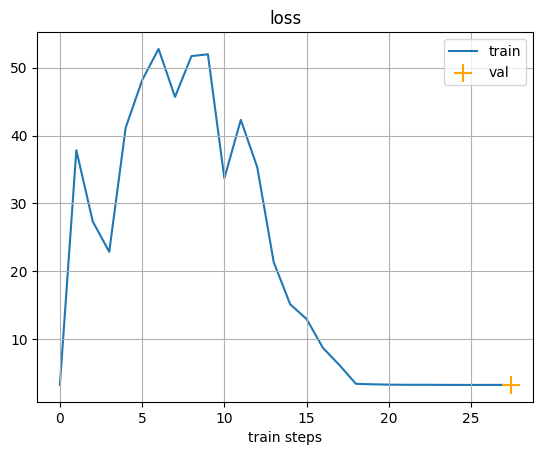

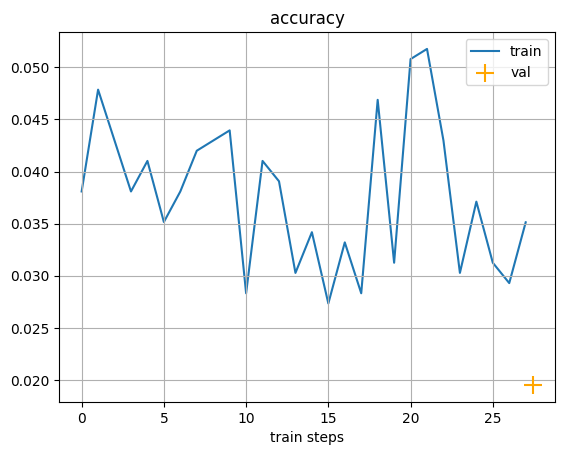

Epoch: 0, val loss: 3.264582633972168, val accuracy: 0.01953125


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

3.25965678691864


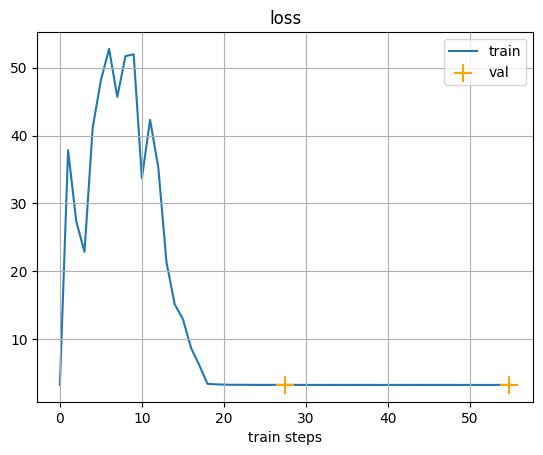

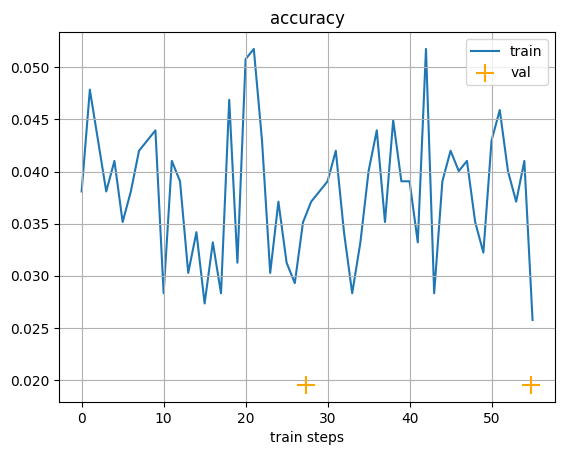

Epoch: 1, val loss: 3.25965678691864, val accuracy: 0.01953125


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

3.259551525115967


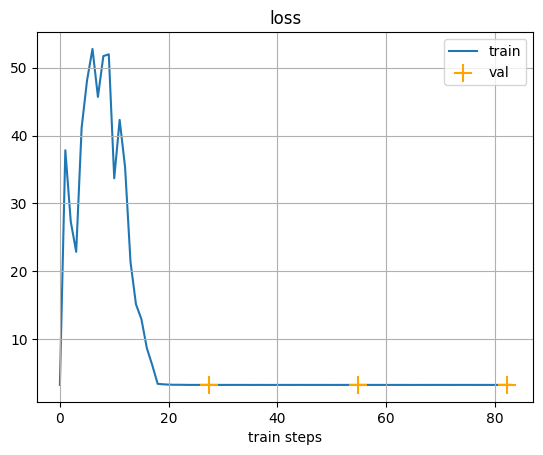

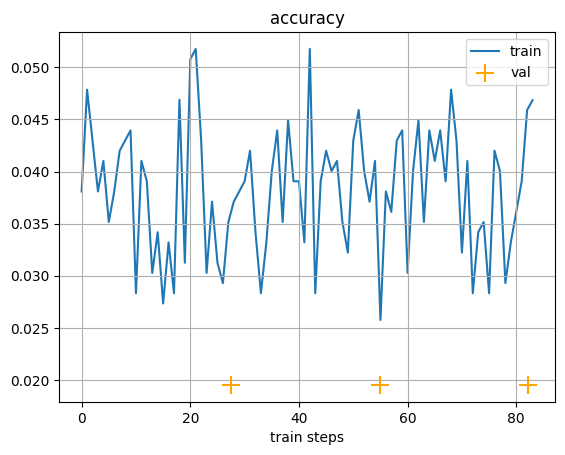

Epoch: 2, val loss: 3.259551525115967, val accuracy: 0.01953125


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

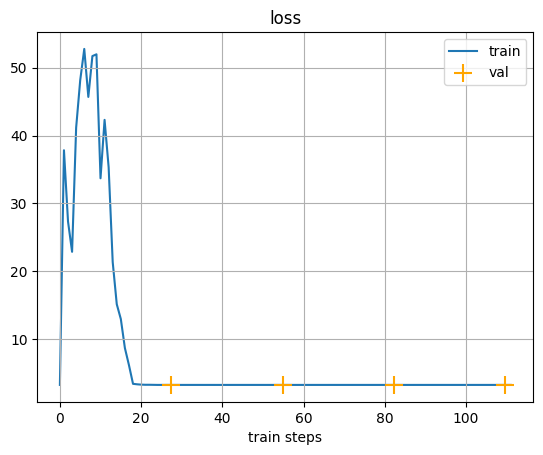

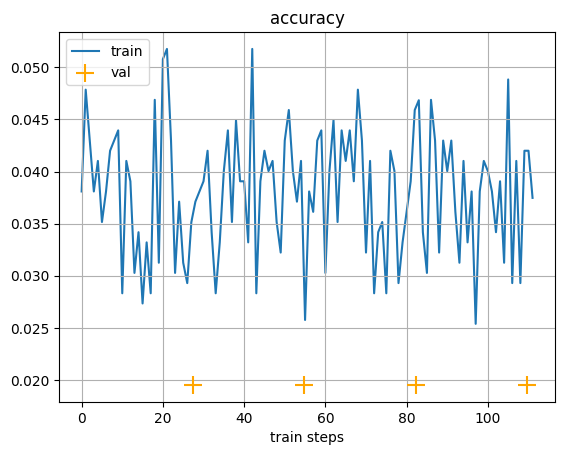

Epoch: 3, val loss: 3.2595614194869995, val accuracy: 0.01953125


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

3.2591230869293213


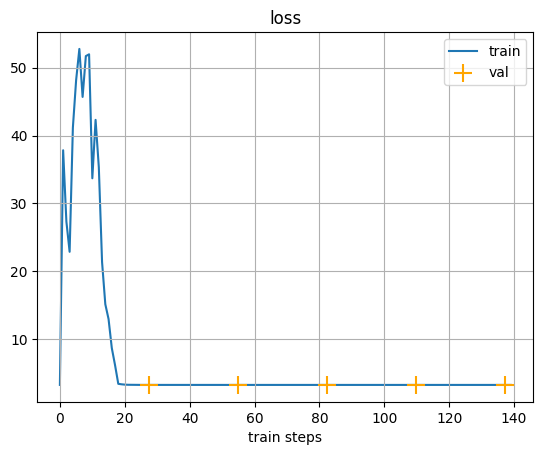

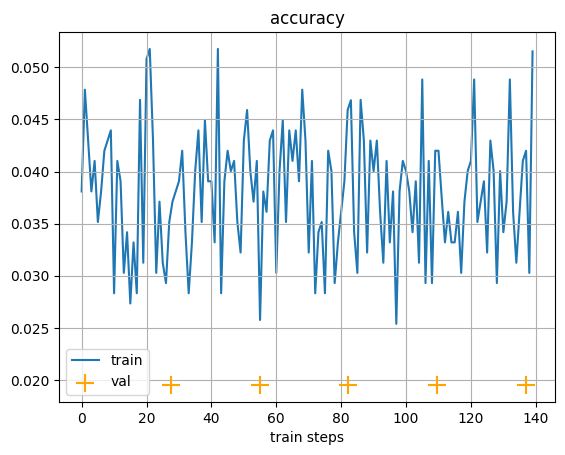

Epoch: 4, val loss: 3.2591230869293213, val accuracy: 0.01953125


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

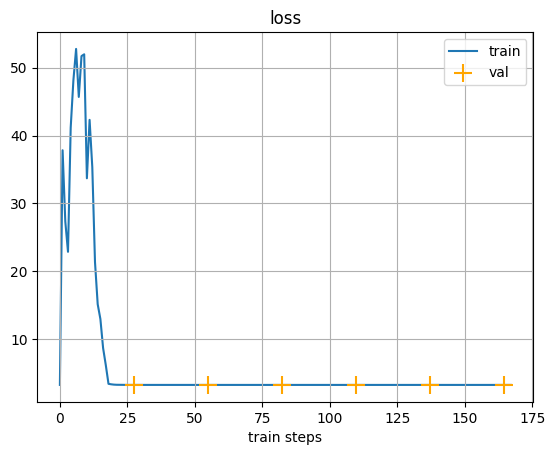

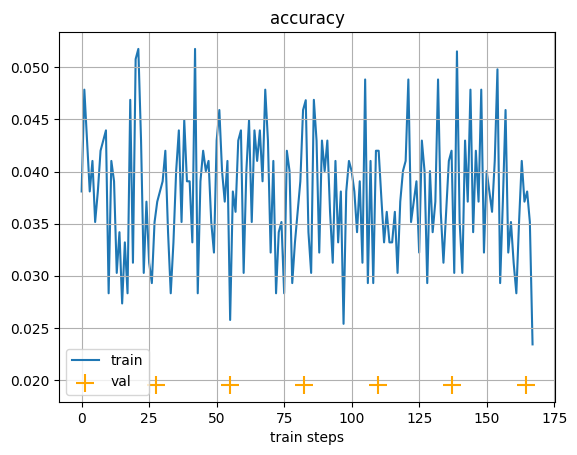

Epoch: 5, val loss: 3.259167432785034, val accuracy: 0.01953125


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

3.2588919401168823


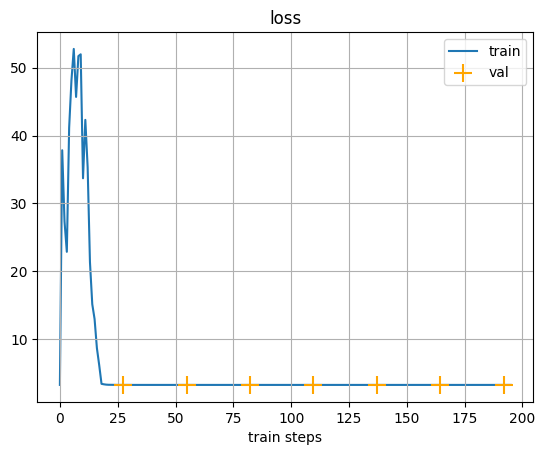

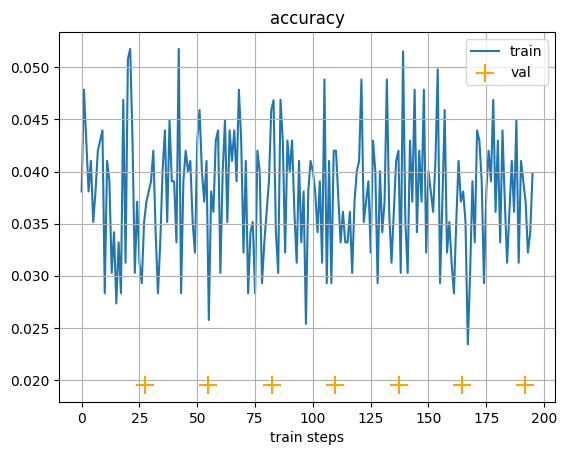

Epoch: 6, val loss: 3.2588919401168823, val accuracy: 0.01953125


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

3.258856177330017


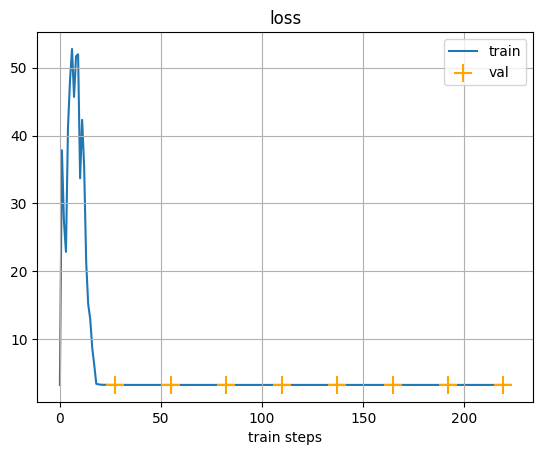

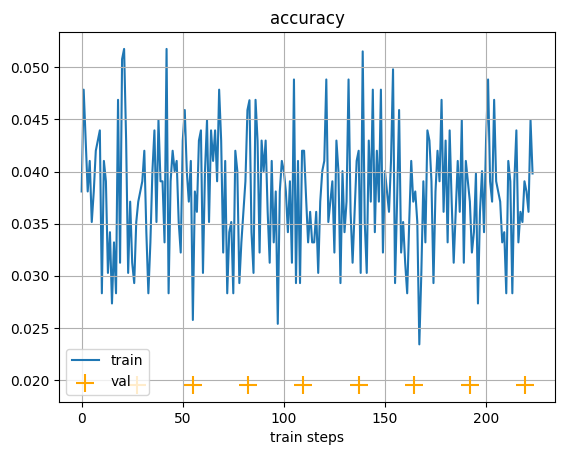

Epoch: 7, val loss: 3.258856177330017, val accuracy: 0.01953125


  0%|          | 0/28 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [95]:
model = CustomCNN()
opt = optim.Adam(model.parameters(), lr=3e-3)

letters_train = DatasetLetters(root=root, train=True, transform=transform_to_tensor)
letters_val = DatasetLetters(root=root, train=False, transform=transform_to_tensor)

trainer = Trainer(model, opt, letters_train, letters_val, batch_size=1024, 
                  root=root, name='cnn')

fix_seed(101)

trainer.train(100)
save_model = Path(root, 'models', 'cnn')
save_model.mkdir(exist_ok=True, parents=True)
torch.save(model.state_dict(), str(Path(save_model, "custom_cnn.pt"))) # важно сохранить веса обученой модели!

# 4 Inference

In [7]:
model = CustomResNet(ResidualBlock, [3, 4, 6, 3])

path = Path(root, 'models', 'resnet')
path.mkdir(exist_ok=True, parents=True)
path = str(Path(path, "best_checkpoint.pth"))

if torch.cuda.is_available():
  model.load_state_dict(torch.load(path))
else:
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
model.eval()

CustomResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1

In [11]:
def image_to_predict(idx: int, transform = transform_to_tensor) -> np.array:
  img_path = os.path.join(root, 'pictures_to_predict', str(idx) + '.png')
  image = Image.open(img_path)
  image = np.array(image)[:300, :300, :]
  # print(image.shape)
  if transform:
    image = transform(image)
    # print(image.shape)
    image = image.reshape(-1, 300, 300)
  else:
    image = np.array(image).reshape(-1, 300, 300)

  return image

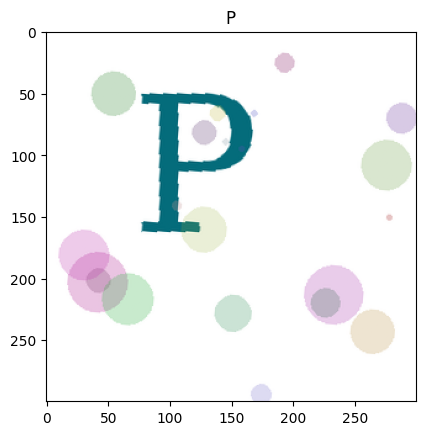

In [14]:
img = image_to_predict(1).unsqueeze(0)
display_img = np.moveaxis(img[0].numpy(), 0, -1)
plt.imshow(display_img)

pred_letter = idx_to_label[int(model.forward(img).argmax(axis=1))]

_ = plt.title(pred_letter)

In [ ]:
letters = {}
for i in tqdm(range(10_000)):
  img = image_to_predict(i).unsqueeze(0)
  pred_letter = idx_to_label[int(model.forward(img).argmax(axis=1))]
  if pred_letter in letters:
    letters[pred_letter] += 1
  else:
    letters[pred_letter] = 1

  0%|          | 0/10000 [00:00<?, ?it/s]

In [136]:
answer = pd.DataFrame(letters)
answer.to_csv(str(Path(root, 'answer.csv')))

'H'

### Appendix

In [ ]:
from collections import namedtuple, OrderedDict
Color = namedtuple('RGB','red, green, blue')
colors = {} #dict of colors
class RGB(Color):
    def hex_format(self):
      '''Returns color in hex format'''
      return '#{:02X}{:02X}{:02X}'.format(self.red,self.green,self.blue)
    def value(self):
      return (self.red,self.green,self.blue)
#Color Contants
ALICEBLUE = RGB(240, 248, 255)
ANTIQUEWHITE = RGB(250, 235, 215)
ANTIQUEWHITE1 = RGB(255, 239, 219)
ANTIQUEWHITE2 = RGB(238, 223, 204)
ANTIQUEWHITE3 = RGB(205, 192, 176)
ANTIQUEWHITE4 = RGB(139, 131, 120)
AQUA = RGB(0, 255, 255)
AQUAMARINE1 = RGB(127, 255, 212)
AQUAMARINE2 = RGB(118, 238, 198)
AQUAMARINE3 = RGB(102, 205, 170)
AQUAMARINE4 = RGB(69, 139, 116)
AZURE1 = RGB(240, 255, 255)
AZURE2 = RGB(224, 238, 238)
AZURE3 = RGB(193, 205, 205)
AZURE4 = RGB(131, 139, 139)
BANANA = RGB(227, 207, 87)
BEIGE = RGB(245, 245, 220)
BISQUE1 = RGB(255, 228, 196)
BISQUE2 = RGB(238, 213, 183)
BISQUE3 = RGB(205, 183, 158)
BISQUE4 = RGB(139, 125, 107)
BLACK = RGB(0, 0, 0)
BLANCHEDALMOND = RGB(255, 235, 205)
BLUE = RGB(0, 0, 255)
BLUE2 = RGB(0, 0, 238)
BLUE3 = RGB(0, 0, 205)
BLUE4 = RGB(0, 0, 139)
BLUEVIOLET = RGB(138, 43, 226)
BRICK = RGB(156, 102, 31)
BROWN = RGB(165, 42, 42)
BROWN1 = RGB(255, 64, 64)
BROWN2 = RGB(238, 59, 59)
BROWN3 = RGB(205, 51, 51)
BROWN4 = RGB(139, 35, 35)
BURLYWOOD = RGB(222, 184, 135)
BURLYWOOD1 = RGB(255, 211, 155)
BURLYWOOD2 = RGB(238, 197, 145)
BURLYWOOD3 = RGB(205, 170, 125)
BURLYWOOD4 = RGB(139, 115, 85)
BURNTSIENNA = RGB(138, 54, 15)
BURNTUMBER = RGB(138, 51, 36)
CADETBLUE = RGB(95, 158, 160)
CADETBLUE1 = RGB(152, 245, 255)
CADETBLUE2 = RGB(142, 229, 238)
CADETBLUE3 = RGB(122, 197, 205)
CADETBLUE4 = RGB(83, 134, 139)
CADMIUMORANGE = RGB(255, 97, 3)
CADMIUMYELLOW = RGB(255, 153, 18)
CARROT = RGB(237, 145, 33)
CHARTREUSE1 = RGB(127, 255, 0)
CHARTREUSE2 = RGB(118, 238, 0)
CHARTREUSE3 = RGB(102, 205, 0)
CHARTREUSE4 = RGB(69, 139, 0)
CHOCOLATE = RGB(210, 105, 30)
CHOCOLATE1 = RGB(255, 127, 36)
CHOCOLATE2 = RGB(238, 118, 33)
CHOCOLATE3 = RGB(205, 102, 29)
CHOCOLATE4 = RGB(139, 69, 19)
COBALT = RGB(61, 89, 171)
COBALTGREEN = RGB(61, 145, 64)
COLDGREY = RGB(128, 138, 135)
CORAL = RGB(255, 127, 80)
CORAL1 = RGB(255, 114, 86)
CORAL2 = RGB(238, 106, 80)
CORAL3 = RGB(205, 91, 69)
CORAL4 = RGB(139, 62, 47)
CORNFLOWERBLUE = RGB(100, 149, 237)
CORNSILK1 = RGB(255, 248, 220)
CORNSILK2 = RGB(238, 232, 205)
CORNSILK3 = RGB(205, 200, 177)
CORNSILK4 = RGB(139, 136, 120)
CRIMSON = RGB(220, 20, 60)
CYAN2 = RGB(0, 238, 238)
CYAN3 = RGB(0, 205, 205)
CYAN4 = RGB(0, 139, 139)
DARKGOLDENROD = RGB(184, 134, 11)
DARKGOLDENROD1 = RGB(255, 185, 15)
DARKGOLDENROD2 = RGB(238, 173, 14)
DARKGOLDENROD3 = RGB(205, 149, 12)
DARKGOLDENROD4 = RGB(139, 101, 8)
DARKGRAY = RGB(169, 169, 169)
DARKGREEN = RGB(0, 100, 0)
DARKKHAKI = RGB(189, 183, 107)
DARKOLIVEGREEN = RGB(85, 107, 47)
DARKOLIVEGREEN1 = RGB(202, 255, 112)
DARKOLIVEGREEN2 = RGB(188, 238, 104)
DARKOLIVEGREEN3 = RGB(162, 205, 90)
DARKOLIVEGREEN4 = RGB(110, 139, 61)
DARKORANGE = RGB(255, 140, 0)
DARKORANGE1 = RGB(255, 127, 0)
DARKORANGE2 = RGB(238, 118, 0)
DARKORANGE3 = RGB(205, 102, 0)
DARKORANGE4 = RGB(139, 69, 0)
DARKORCHID = RGB(153, 50, 204)
DARKORCHID1 = RGB(191, 62, 255)
DARKORCHID2 = RGB(178, 58, 238)
DARKORCHID3 = RGB(154, 50, 205)
DARKORCHID4 = RGB(104, 34, 139)
DARKSALMON = RGB(233, 150, 122)
DARKSEAGREEN = RGB(143, 188, 143)
DARKSEAGREEN1 = RGB(193, 255, 193)
DARKSEAGREEN2 = RGB(180, 238, 180)
DARKSEAGREEN3 = RGB(155, 205, 155)
DARKSEAGREEN4 = RGB(105, 139, 105)
DARKSLATEBLUE = RGB(72, 61, 139)
DARKSLATEGRAY = RGB(47, 79, 79)
DARKSLATEGRAY1 = RGB(151, 255, 255)
DARKSLATEGRAY2 = RGB(141, 238, 238)
DARKSLATEGRAY3 = RGB(121, 205, 205)
DARKSLATEGRAY4 = RGB(82, 139, 139)
DARKTURQUOISE = RGB(0, 206, 209)
DARKVIOLET = RGB(148, 0, 211)
DEEPPINK1 = RGB(255, 20, 147)
DEEPPINK2 = RGB(238, 18, 137)
DEEPPINK3 = RGB(205, 16, 118)
DEEPPINK4 = RGB(139, 10, 80)
DEEPSKYBLUE1 = RGB(0, 191, 255)
DEEPSKYBLUE2 = RGB(0, 178, 238)
DEEPSKYBLUE3 = RGB(0, 154, 205)
DEEPSKYBLUE4 = RGB(0, 104, 139)
DIMGRAY = RGB(105, 105, 105)
DIMGRAY = RGB(105, 105, 105)
DODGERBLUE1 = RGB(30, 144, 255)
DODGERBLUE2 = RGB(28, 134, 238)
DODGERBLUE3 = RGB(24, 116, 205)
DODGERBLUE4 = RGB(16, 78, 139)
EGGSHELL = RGB(252, 230, 201)
EMERALDGREEN = RGB(0, 201, 87)
FIREBRICK = RGB(178, 34, 34)
FIREBRICK1 = RGB(255, 48, 48)
FIREBRICK2 = RGB(238, 44, 44)
FIREBRICK3 = RGB(205, 38, 38)
FIREBRICK4 = RGB(139, 26, 26)
FLESH = RGB(255, 125, 64)
FLORALWHITE = RGB(255, 250, 240)
FORESTGREEN = RGB(34, 139, 34)
GAINSBORO = RGB(220, 220, 220)
GHOSTWHITE = RGB(248, 248, 255)
GOLD1 = RGB(255, 215, 0)
GOLD2 = RGB(238, 201, 0)
GOLD3 = RGB(205, 173, 0)
GOLD4 = RGB(139, 117, 0)
GOLDENROD = RGB(218, 165, 32)
GOLDENROD1 = RGB(255, 193, 37)
GOLDENROD2 = RGB(238, 180, 34)
GOLDENROD3 = RGB(205, 155, 29)
GOLDENROD4 = RGB(139, 105, 20)
GRAY = RGB(128, 128, 128)
GRAY1 = RGB(3, 3, 3)
GRAY10 = RGB(26, 26, 26)
GRAY11 = RGB(28, 28, 28)
GRAY12 = RGB(31, 31, 31)
GRAY13 = RGB(33, 33, 33)
GRAY14 = RGB(36, 36, 36)
GRAY15 = RGB(38, 38, 38)
GRAY16 = RGB(41, 41, 41)
GRAY17 = RGB(43, 43, 43)
GRAY18 = RGB(46, 46, 46)
GRAY19 = RGB(48, 48, 48)
GRAY2 = RGB(5, 5, 5)
GRAY20 = RGB(51, 51, 51)
GRAY21 = RGB(54, 54, 54)
GRAY22 = RGB(56, 56, 56)
GRAY23 = RGB(59, 59, 59)
GRAY24 = RGB(61, 61, 61)
GRAY25 = RGB(64, 64, 64)
GRAY26 = RGB(66, 66, 66)
GRAY27 = RGB(69, 69, 69)
GRAY28 = RGB(71, 71, 71)
GRAY29 = RGB(74, 74, 74)
GRAY3 = RGB(8, 8, 8)
GRAY30 = RGB(77, 77, 77)
GRAY31 = RGB(79, 79, 79)
GRAY32 = RGB(82, 82, 82)
GRAY33 = RGB(84, 84, 84)
GRAY34 = RGB(87, 87, 87)
GRAY35 = RGB(89, 89, 89)
GRAY36 = RGB(92, 92, 92)
GRAY37 = RGB(94, 94, 94)
GRAY38 = RGB(97, 97, 97)
GRAY39 = RGB(99, 99, 99)
GRAY4 = RGB(10, 10, 10)
GRAY40 = RGB(102, 102, 102)
GRAY42 = RGB(107, 107, 107)
GRAY43 = RGB(110, 110, 110)
GRAY44 = RGB(112, 112, 112)
GRAY45 = RGB(115, 115, 115)
GRAY46 = RGB(117, 117, 117)
GRAY47 = RGB(120, 120, 120)
GRAY48 = RGB(122, 122, 122)
GRAY49 = RGB(125, 125, 125)
GRAY5 = RGB(13, 13, 13)
GRAY50 = RGB(127, 127, 127)
GRAY51 = RGB(130, 130, 130)
GRAY52 = RGB(133, 133, 133)
GRAY53 = RGB(135, 135, 135)
GRAY54 = RGB(138, 138, 138)
GRAY55 = RGB(140, 140, 140)
GRAY56 = RGB(143, 143, 143)
GRAY57 = RGB(145, 145, 145)
GRAY58 = RGB(148, 148, 148)
GRAY59 = RGB(150, 150, 150)
GRAY6 = RGB(15, 15, 15)
GRAY60 = RGB(153, 153, 153)
GRAY61 = RGB(156, 156, 156)
GRAY62 = RGB(158, 158, 158)
GRAY63 = RGB(161, 161, 161)
GRAY64 = RGB(163, 163, 163)
GRAY65 = RGB(166, 166, 166)
GRAY66 = RGB(168, 168, 168)
GRAY67 = RGB(171, 171, 171)
GRAY68 = RGB(173, 173, 173)
GRAY69 = RGB(176, 176, 176)
GRAY7 = RGB(18, 18, 18)
GRAY70 = RGB(179, 179, 179)
GRAY71 = RGB(181, 181, 181)
GRAY72 = RGB(184, 184, 184)
GRAY73 = RGB(186, 186, 186)
GRAY74 = RGB(189, 189, 189)
GRAY75 = RGB(191, 191, 191)
GRAY76 = RGB(194, 194, 194)
GRAY77 = RGB(196, 196, 196)
GRAY78 = RGB(199, 199, 199)
GRAY79 = RGB(201, 201, 201)
GRAY8 = RGB(20, 20, 20)
GRAY80 = RGB(204, 204, 204)
GRAY81 = RGB(207, 207, 207)
GRAY82 = RGB(209, 209, 209)
GRAY83 = RGB(212, 212, 212)
GRAY84 = RGB(214, 214, 214)
GRAY85 = RGB(217, 217, 217)
GRAY86 = RGB(219, 219, 219)
GRAY87 = RGB(222, 222, 222)
GRAY88 = RGB(224, 224, 224)
GRAY89 = RGB(227, 227, 227)
GRAY9 = RGB(23, 23, 23)
GRAY90 = RGB(229, 229, 229)
GRAY91 = RGB(232, 232, 232)
GRAY92 = RGB(235, 235, 235)
GRAY93 = RGB(237, 237, 237)
GRAY94 = RGB(240, 240, 240)
GRAY95 = RGB(242, 242, 242)
GRAY97 = RGB(247, 247, 247)
GRAY98 = RGB(250, 250, 250)
GRAY99 = RGB(252, 252, 252)
GREEN = RGB(0, 128, 0)
GREEN1 = RGB(0, 255, 0)
GREEN2 = RGB(0, 238, 0)
GREEN3 = RGB(0, 205, 0)
GREEN4 = RGB(0, 139, 0)
GREENYELLOW = RGB(173, 255, 47)
HONEYDEW1 = RGB(240, 255, 240)
HONEYDEW2 = RGB(224, 238, 224)
HONEYDEW3 = RGB(193, 205, 193)
HONEYDEW4 = RGB(131, 139, 131)
HOTPINK = RGB(255, 105, 180)
HOTPINK1 = RGB(255, 110, 180)
HOTPINK2 = RGB(238, 106, 167)
HOTPINK3 = RGB(205, 96, 144)
HOTPINK4 = RGB(139, 58, 98)
INDIANRED = RGB(176, 23, 31)
INDIANRED = RGB(205, 92, 92)
INDIANRED1 = RGB(255, 106, 106)
INDIANRED2 = RGB(238, 99, 99)
INDIANRED3 = RGB(205, 85, 85)
INDIANRED4 = RGB(139, 58, 58)
INDIGO = RGB(75, 0, 130)
IVORY1 = RGB(255, 255, 240)
IVORY2 = RGB(238, 238, 224)
IVORY3 = RGB(205, 205, 193)
IVORY4 = RGB(139, 139, 131)
IVORYBLACK = RGB(41, 36, 33)
KHAKI = RGB(240, 230, 140)
KHAKI1 = RGB(255, 246, 143)
KHAKI2 = RGB(238, 230, 133)
KHAKI3 = RGB(205, 198, 115)
KHAKI4 = RGB(139, 134, 78)
LAVENDER = RGB(230, 230, 250)
LAVENDERBLUSH1 = RGB(255, 240, 245)
LAVENDERBLUSH2 = RGB(238, 224, 229)
LAVENDERBLUSH3 = RGB(205, 193, 197)
LAVENDERBLUSH4 = RGB(139, 131, 134)
LAWNGREEN = RGB(124, 252, 0)
LEMONCHIFFON1 = RGB(255, 250, 205)
LEMONCHIFFON2 = RGB(238, 233, 191)
LEMONCHIFFON3 = RGB(205, 201, 165)
LEMONCHIFFON4 = RGB(139, 137, 112)
LIGHTBLUE = RGB(173, 216, 230)
LIGHTBLUE1 = RGB(191, 239, 255)
LIGHTBLUE2 = RGB(178, 223, 238)
LIGHTBLUE3 = RGB(154, 192, 205)
LIGHTBLUE4 = RGB(104, 131, 139)
LIGHTCORAL = RGB(240, 128, 128)
LIGHTCYAN1 = RGB(224, 255, 255)
LIGHTCYAN2 = RGB(209, 238, 238)
LIGHTCYAN3 = RGB(180, 205, 205)
LIGHTCYAN4 = RGB(122, 139, 139)
LIGHTGOLDENROD1 = RGB(255, 236, 139)
LIGHTGOLDENROD2 = RGB(238, 220, 130)
LIGHTGOLDENROD3 = RGB(205, 190, 112)
LIGHTGOLDENROD4 = RGB(139, 129, 76)
LIGHTGOLDENRODYELLOW = RGB(250, 250, 210)
LIGHTGREY = RGB(211, 211, 211)
LIGHTPINK = RGB(255, 182, 193)
LIGHTPINK1 = RGB(255, 174, 185)
LIGHTPINK2 = RGB(238, 162, 173)
LIGHTPINK3 = RGB(205, 140, 149)
LIGHTPINK4 = RGB(139, 95, 101)
LIGHTSALMON1 = RGB(255, 160, 122)
LIGHTSALMON2 = RGB(238, 149, 114)
LIGHTSALMON3 = RGB(205, 129, 98)
LIGHTSALMON4 = RGB(139, 87, 66)
LIGHTSEAGREEN = RGB(32, 178, 170)
LIGHTSKYBLUE = RGB(135, 206, 250)
LIGHTSKYBLUE1 = RGB(176, 226, 255)
LIGHTSKYBLUE2 = RGB(164, 211, 238)
LIGHTSKYBLUE3 = RGB(141, 182, 205)
LIGHTSKYBLUE4 = RGB(96, 123, 139)
LIGHTSLATEBLUE = RGB(132, 112, 255)
LIGHTSLATEGRAY = RGB(119, 136, 153)
LIGHTSTEELBLUE = RGB(176, 196, 222)
LIGHTSTEELBLUE1 = RGB(202, 225, 255)
LIGHTSTEELBLUE2 = RGB(188, 210, 238)
LIGHTSTEELBLUE3 = RGB(162, 181, 205)
LIGHTSTEELBLUE4 = RGB(110, 123, 139)
LIGHTYELLOW1 = RGB(255, 255, 224)
LIGHTYELLOW2 = RGB(238, 238, 209)
LIGHTYELLOW3 = RGB(205, 205, 180)
LIGHTYELLOW4 = RGB(139, 139, 122)
LIMEGREEN = RGB(50, 205, 50)
LINEN = RGB(250, 240, 230)
MAGENTA = RGB(255, 0, 255)
MAGENTA2 = RGB(238, 0, 238)
MAGENTA3 = RGB(205, 0, 205)
MAGENTA4 = RGB(139, 0, 139)
MANGANESEBLUE = RGB(3, 168, 158)
MAROON = RGB(128, 0, 0)
MAROON1 = RGB(255, 52, 179)
MAROON2 = RGB(238, 48, 167)
MAROON3 = RGB(205, 41, 144)
MAROON4 = RGB(139, 28, 98)
MEDIUMORCHID = RGB(186, 85, 211)
MEDIUMORCHID1 = RGB(224, 102, 255)
MEDIUMORCHID2 = RGB(209, 95, 238)
MEDIUMORCHID3 = RGB(180, 82, 205)
MEDIUMORCHID4 = RGB(122, 55, 139)
MEDIUMPURPLE = RGB(147, 112, 219)
MEDIUMPURPLE1 = RGB(171, 130, 255)
MEDIUMPURPLE2 = RGB(159, 121, 238)
MEDIUMPURPLE3 = RGB(137, 104, 205)
MEDIUMPURPLE4 = RGB(93, 71, 139)
MEDIUMSEAGREEN = RGB(60, 179, 113)
MEDIUMSLATEBLUE = RGB(123, 104, 238)
MEDIUMSPRINGGREEN = RGB(0, 250, 154)
MEDIUMTURQUOISE = RGB(72, 209, 204)
MEDIUMVIOLETRED = RGB(199, 21, 133)
MELON = RGB(227, 168, 105)
MIDNIGHTBLUE = RGB(25, 25, 112)
MINT = RGB(189, 252, 201)
MINTCREAM = RGB(245, 255, 250)
MISTYROSE1 = RGB(255, 228, 225)
MISTYROSE2 = RGB(238, 213, 210)
MISTYROSE3 = RGB(205, 183, 181)
MISTYROSE4 = RGB(139, 125, 123)
MOCCASIN = RGB(255, 228, 181)
NAVAJOWHITE1 = RGB(255, 222, 173)
NAVAJOWHITE2 = RGB(238, 207, 161)
NAVAJOWHITE3 = RGB(205, 179, 139)
NAVAJOWHITE4 = RGB(139, 121, 94)
NAVY = RGB(0, 0, 128)
OLDLACE = RGB(253, 245, 230)
OLIVE = RGB(128, 128, 0)
OLIVEDRAB = RGB(107, 142, 35)
OLIVEDRAB1 = RGB(192, 255, 62)
OLIVEDRAB2 = RGB(179, 238, 58)
OLIVEDRAB3 = RGB(154, 205, 50)
OLIVEDRAB4 = RGB(105, 139, 34)
ORANGE = RGB(255, 128, 0)
ORANGE1 = RGB(255, 165, 0)
ORANGE2 = RGB(238, 154, 0)
ORANGE3 = RGB(205, 133, 0)
ORANGE4 = RGB(139, 90, 0)
ORANGERED1 = RGB(255, 69, 0)
ORANGERED2 = RGB(238, 64, 0)
ORANGERED3 = RGB(205, 55, 0)
ORANGERED4 = RGB(139, 37, 0)
ORCHID = RGB(218, 112, 214)
ORCHID1 = RGB(255, 131, 250)
ORCHID2 = RGB(238, 122, 233)
ORCHID3 = RGB(205, 105, 201)
ORCHID4 = RGB(139, 71, 137)
PALEGOLDENROD = RGB(238, 232, 170)
PALEGREEN = RGB(152, 251, 152)
PALEGREEN1 = RGB(154, 255, 154)
PALEGREEN2 = RGB(144, 238, 144)
PALEGREEN3 = RGB(124, 205, 124)
PALEGREEN4 = RGB(84, 139, 84)
PALETURQUOISE1 = RGB(187, 255, 255)
PALETURQUOISE2 = RGB(174, 238, 238)
PALETURQUOISE3 = RGB(150, 205, 205)
PALETURQUOISE4 = RGB(102, 139, 139)
PALEVIOLETRED = RGB(219, 112, 147)
PALEVIOLETRED1 = RGB(255, 130, 171)
PALEVIOLETRED2 = RGB(238, 121, 159)
PALEVIOLETRED3 = RGB(205, 104, 137)
PALEVIOLETRED4 = RGB(139, 71, 93)
PAPAYAWHIP = RGB(255, 239, 213)
PEACHPUFF1 = RGB(255, 218, 185)
PEACHPUFF2 = RGB(238, 203, 173)
PEACHPUFF3 = RGB(205, 175, 149)
PEACHPUFF4 = RGB(139, 119, 101)
PEACOCK = RGB(51, 161, 201)
PINK = RGB(255, 192, 203)
PINK1 = RGB(255, 181, 197)
PINK2 = RGB(238, 169, 184)
PINK3 = RGB(205, 145, 158)
PINK4 = RGB(139, 99, 108)
PLUM = RGB(221, 160, 221)
PLUM1 = RGB(255, 187, 255)
PLUM2 = RGB(238, 174, 238)
PLUM3 = RGB(205, 150, 205)
PLUM4 = RGB(139, 102, 139)
POWDERBLUE = RGB(176, 224, 230)
PURPLE = RGB(128, 0, 128)
PURPLE1 = RGB(155, 48, 255)
PURPLE2 = RGB(145, 44, 238)
PURPLE3 = RGB(125, 38, 205)
PURPLE4 = RGB(85, 26, 139)
RASPBERRY = RGB(135, 38, 87)
RAWSIENNA = RGB(199, 97, 20)
RED1 = RGB(255, 0, 0)
RED2 = RGB(238, 0, 0)
RED3 = RGB(205, 0, 0)
RED4 = RGB(139, 0, 0)
ROSYBROWN = RGB(188, 143, 143)
ROSYBROWN1 = RGB(255, 193, 193)
ROSYBROWN2 = RGB(238, 180, 180)
ROSYBROWN3 = RGB(205, 155, 155)
ROSYBROWN4 = RGB(139, 105, 105)
ROYALBLUE = RGB(65, 105, 225)
ROYALBLUE1 = RGB(72, 118, 255)
ROYALBLUE2 = RGB(67, 110, 238)
ROYALBLUE3 = RGB(58, 95, 205)
ROYALBLUE4 = RGB(39, 64, 139)
SALMON = RGB(250, 128, 114)
SALMON1 = RGB(255, 140, 105)
SALMON2 = RGB(238, 130, 98)
SALMON3 = RGB(205, 112, 84)
SALMON4 = RGB(139, 76, 57)
SANDYBROWN = RGB(244, 164, 96)
SAPGREEN = RGB(48, 128, 20)
SEAGREEN1 = RGB(84, 255, 159)
SEAGREEN2 = RGB(78, 238, 148)
SEAGREEN3 = RGB(67, 205, 128)
SEAGREEN4 = RGB(46, 139, 87)
SEASHELL1 = RGB(255, 245, 238)
SEASHELL2 = RGB(238, 229, 222)
SEASHELL3 = RGB(205, 197, 191)
SEASHELL4 = RGB(139, 134, 130)
SEPIA = RGB(94, 38, 18)
SGIBEET = RGB(142, 56, 142)
SGIBRIGHTGRAY = RGB(197, 193, 170)
SGICHARTREUSE = RGB(113, 198, 113)
SGIDARKGRAY = RGB(85, 85, 85)
SGIGRAY12 = RGB(30, 30, 30)
SGIGRAY16 = RGB(40, 40, 40)
SGIGRAY32 = RGB(81, 81, 81)
SGIGRAY36 = RGB(91, 91, 91)
SGIGRAY52 = RGB(132, 132, 132)
SGIGRAY56 = RGB(142, 142, 142)
SGIGRAY72 = RGB(183, 183, 183)
SGIGRAY76 = RGB(193, 193, 193)
SGIGRAY92 = RGB(234, 234, 234)
SGIGRAY96 = RGB(244, 244, 244)
SGILIGHTBLUE = RGB(125, 158, 192)
SGILIGHTGRAY = RGB(170, 170, 170)
SGIOLIVEDRAB = RGB(142, 142, 56)
SGISALMON = RGB(198, 113, 113)
SGISLATEBLUE = RGB(113, 113, 198)
SGITEAL = RGB(56, 142, 142)
SIENNA = RGB(160, 82, 45)
SIENNA1 = RGB(255, 130, 71)
SIENNA2 = RGB(238, 121, 66)
SIENNA3 = RGB(205, 104, 57)
SIENNA4 = RGB(139, 71, 38)
SILVER = RGB(192, 192, 192)
SKYBLUE = RGB(135, 206, 235)
SKYBLUE1 = RGB(135, 206, 255)
SKYBLUE2 = RGB(126, 192, 238)
SKYBLUE3 = RGB(108, 166, 205)
SKYBLUE4 = RGB(74, 112, 139)
SLATEBLUE = RGB(106, 90, 205)
SLATEBLUE1 = RGB(131, 111, 255)
SLATEBLUE2 = RGB(122, 103, 238)
SLATEBLUE3 = RGB(105, 89, 205)
SLATEBLUE4 = RGB(71, 60, 139)
SLATEGRAY = RGB(112, 128, 144)
SLATEGRAY1 = RGB(198, 226, 255)
SLATEGRAY2 = RGB(185, 211, 238)
SLATEGRAY3 = RGB(159, 182, 205)
SLATEGRAY4 = RGB(108, 123, 139)
SNOW1 = RGB(255, 250, 250)
SNOW2 = RGB(238, 233, 233)
SNOW3 = RGB(205, 201, 201)
SNOW4 = RGB(139, 137, 137)
SPRINGGREEN = RGB(0, 255, 127)
SPRINGGREEN1 = RGB(0, 238, 118)
SPRINGGREEN2 = RGB(0, 205, 102)
SPRINGGREEN3 = RGB(0, 139, 69)
STEELBLUE = RGB(70, 130, 180)
STEELBLUE1 = RGB(99, 184, 255)
STEELBLUE2 = RGB(92, 172, 238)
STEELBLUE3 = RGB(79, 148, 205)
STEELBLUE4 = RGB(54, 100, 139)
TAN = RGB(210, 180, 140)
TAN1 = RGB(255, 165, 79)
TAN2 = RGB(238, 154, 73)
TAN3 = RGB(205, 133, 63)
TAN4 = RGB(139, 90, 43)
TEAL = RGB(0, 128, 128)
THISTLE = RGB(216, 191, 216)
THISTLE1 = RGB(255, 225, 255)
THISTLE2 = RGB(238, 210, 238)
THISTLE3 = RGB(205, 181, 205)
THISTLE4 = RGB(139, 123, 139)
TOMATO1 = RGB(255, 99, 71)
TOMATO2 = RGB(238, 92, 66)
TOMATO3 = RGB(205, 79, 57)
TOMATO4 = RGB(139, 54, 38)
TURQUOISE = RGB(64, 224, 208)
TURQUOISE1 = RGB(0, 245, 255)
TURQUOISE2 = RGB(0, 229, 238)
TURQUOISE3 = RGB(0, 197, 205)
TURQUOISE4 = RGB(0, 134, 139)
TURQUOISEBLUE = RGB(0, 199, 140)
VIOLET = RGB(238, 130, 238)
VIOLETRED = RGB(208, 32, 144)
VIOLETRED1 = RGB(255, 62, 150)
VIOLETRED2 = RGB(238, 58, 140)
VIOLETRED3 = RGB(205, 50, 120)
VIOLETRED4 = RGB(139, 34, 82)
WARMGREY = RGB(128, 128, 105)
WHEAT = RGB(245, 222, 179)
WHEAT1 = RGB(255, 231, 186)
WHEAT2 = RGB(238, 216, 174)
WHEAT3 = RGB(205, 186, 150)
WHEAT4 = RGB(139, 126, 102)
WHITE = RGB(255, 255, 255)
WHITESMOKE = RGB(245, 245, 245)
WHITESMOKE = RGB(245, 245, 245)
YELLOW1 = RGB(255, 255, 0)
YELLOW2 = RGB(238, 238, 0)
YELLOW3 = RGB(205, 205, 0)
YELLOW4 = RGB(139, 139, 0)
#Add colors to colors dictionary
colors['aliceblue'] = ALICEBLUE
colors['antiquewhite'] = ANTIQUEWHITE
colors['antiquewhite1'] = ANTIQUEWHITE1
colors['antiquewhite2'] = ANTIQUEWHITE2
colors['antiquewhite3'] = ANTIQUEWHITE3
colors['antiquewhite4'] = ANTIQUEWHITE4
colors['aqua'] = AQUA
colors['aquamarine1'] = AQUAMARINE1
colors['aquamarine2'] = AQUAMARINE2
colors['aquamarine3'] = AQUAMARINE3
colors['aquamarine4'] = AQUAMARINE4
colors['azure1'] = AZURE1
colors['azure2'] = AZURE2
colors['azure3'] = AZURE3
colors['azure4'] = AZURE4
colors['banana'] = BANANA
colors['beige'] = BEIGE
colors['bisque1'] = BISQUE1
colors['bisque2'] = BISQUE2
colors['bisque3'] = BISQUE3
colors['bisque4'] = BISQUE4
colors['black'] = BLACK
colors['blanchedalmond'] = BLANCHEDALMOND
colors['blue'] = BLUE
colors['blue2'] = BLUE2
colors['blue3'] = BLUE3
colors['blue4'] = BLUE4
colors['blueviolet'] = BLUEVIOLET
colors['brick'] = BRICK
colors['brown'] = BROWN
colors['brown1'] = BROWN1
colors['brown2'] = BROWN2
colors['brown3'] = BROWN3
colors['brown4'] = BROWN4
colors['burlywood'] = BURLYWOOD
colors['burlywood1'] = BURLYWOOD1
colors['burlywood2'] = BURLYWOOD2
colors['burlywood3'] = BURLYWOOD3
colors['burlywood4'] = BURLYWOOD4
colors['burntsienna'] = BURNTSIENNA
colors['burntumber'] = BURNTUMBER
colors['cadetblue'] = CADETBLUE
colors['cadetblue1'] = CADETBLUE1
colors['cadetblue2'] = CADETBLUE2
colors['cadetblue3'] = CADETBLUE3
colors['cadetblue4'] = CADETBLUE4
colors['cadmiumorange'] = CADMIUMORANGE
colors['cadmiumyellow'] = CADMIUMYELLOW
colors['carrot'] = CARROT
colors['chartreuse1'] = CHARTREUSE1
colors['chartreuse2'] = CHARTREUSE2
colors['chartreuse3'] = CHARTREUSE3
colors['chartreuse4'] = CHARTREUSE4
colors['chocolate'] = CHOCOLATE
colors['chocolate1'] = CHOCOLATE1
colors['chocolate2'] = CHOCOLATE2
colors['chocolate3'] = CHOCOLATE3
colors['chocolate4'] = CHOCOLATE4
colors['cobalt'] = COBALT
colors['cobaltgreen'] = COBALTGREEN
colors['coldgrey'] = COLDGREY
colors['coral'] = CORAL
colors['coral1'] = CORAL1
colors['coral2'] = CORAL2
colors['coral3'] = CORAL3
colors['coral4'] = CORAL4
colors['cornflowerblue'] = CORNFLOWERBLUE
colors['cornsilk1'] = CORNSILK1
colors['cornsilk2'] = CORNSILK2
colors['cornsilk3'] = CORNSILK3
colors['cornsilk4'] = CORNSILK4
colors['crimson'] = CRIMSON
colors['cyan2'] = CYAN2
colors['cyan3'] = CYAN3
colors['cyan4'] = CYAN4
colors['darkgoldenrod'] = DARKGOLDENROD
colors['darkgoldenrod1'] = DARKGOLDENROD1
colors['darkgoldenrod2'] = DARKGOLDENROD2
colors['darkgoldenrod3'] = DARKGOLDENROD3
colors['darkgoldenrod4'] = DARKGOLDENROD4
colors['darkgray'] = DARKGRAY
colors['darkgreen'] = DARKGREEN
colors['darkkhaki'] = DARKKHAKI
colors['darkolivegreen'] = DARKOLIVEGREEN
colors['darkolivegreen1'] = DARKOLIVEGREEN1
colors['darkolivegreen2'] = DARKOLIVEGREEN2
colors['darkolivegreen3'] = DARKOLIVEGREEN3
colors['darkolivegreen4'] = DARKOLIVEGREEN4
colors['darkorange'] = DARKORANGE
colors['darkorange1'] = DARKORANGE1
colors['darkorange2'] = DARKORANGE2
colors['darkorange3'] = DARKORANGE3
colors['darkorange4'] = DARKORANGE4
colors['darkorchid'] = DARKORCHID
colors['darkorchid1'] = DARKORCHID1
colors['darkorchid2'] = DARKORCHID2
colors['darkorchid3'] = DARKORCHID3
colors['darkorchid4'] = DARKORCHID4
colors['darksalmon'] = DARKSALMON
colors['darkseagreen'] = DARKSEAGREEN
colors['darkseagreen1'] = DARKSEAGREEN1
colors['darkseagreen2'] = DARKSEAGREEN2
colors['darkseagreen3'] = DARKSEAGREEN3
colors['darkseagreen4'] = DARKSEAGREEN4
colors['darkslateblue'] = DARKSLATEBLUE
colors['darkslategray'] = DARKSLATEGRAY
colors['darkslategray1'] = DARKSLATEGRAY1
colors['darkslategray2'] = DARKSLATEGRAY2
colors['darkslategray3'] = DARKSLATEGRAY3
colors['darkslategray4'] = DARKSLATEGRAY4
colors['darkturquoise'] = DARKTURQUOISE
colors['darkviolet'] = DARKVIOLET
colors['deeppink1'] = DEEPPINK1
colors['deeppink2'] = DEEPPINK2
colors['deeppink3'] = DEEPPINK3
colors['deeppink4'] = DEEPPINK4
colors['deepskyblue1'] = DEEPSKYBLUE1
colors['deepskyblue2'] = DEEPSKYBLUE2
colors['deepskyblue3'] = DEEPSKYBLUE3
colors['deepskyblue4'] = DEEPSKYBLUE4
colors['dimgray'] = DIMGRAY
colors['dimgray'] = DIMGRAY
colors['dodgerblue1'] = DODGERBLUE1
colors['dodgerblue2'] = DODGERBLUE2
colors['dodgerblue3'] = DODGERBLUE3
colors['dodgerblue4'] = DODGERBLUE4
colors['eggshell'] = EGGSHELL
colors['emeraldgreen'] = EMERALDGREEN
colors['firebrick'] = FIREBRICK
colors['firebrick1'] = FIREBRICK1
colors['firebrick2'] = FIREBRICK2
colors['firebrick3'] = FIREBRICK3
colors['firebrick4'] = FIREBRICK4
colors['flesh'] = FLESH
colors['floralwhite'] = FLORALWHITE
colors['forestgreen'] = FORESTGREEN
colors['gainsboro'] = GAINSBORO
colors['ghostwhite'] = GHOSTWHITE
colors['gold1'] = GOLD1
colors['gold2'] = GOLD2
colors['gold3'] = GOLD3
colors['gold4'] = GOLD4
colors['goldenrod'] = GOLDENROD
colors['goldenrod1'] = GOLDENROD1
colors['goldenrod2'] = GOLDENROD2
colors['goldenrod3'] = GOLDENROD3
colors['goldenrod4'] = GOLDENROD4
colors['gray'] = GRAY
colors['gray1'] = GRAY1
colors['gray10'] = GRAY10
colors['gray11'] = GRAY11
colors['gray12'] = GRAY12
colors['gray13'] = GRAY13
colors['gray14'] = GRAY14
colors['gray15'] = GRAY15
colors['gray16'] = GRAY16
colors['gray17'] = GRAY17
colors['gray18'] = GRAY18
colors['gray19'] = GRAY19
colors['gray2'] = GRAY2
colors['gray20'] = GRAY20
colors['gray21'] = GRAY21
colors['gray22'] = GRAY22
colors['gray23'] = GRAY23
colors['gray24'] = GRAY24
colors['gray25'] = GRAY25
colors['gray26'] = GRAY26
colors['gray27'] = GRAY27
colors['gray28'] = GRAY28
colors['gray29'] = GRAY29
colors['gray3'] = GRAY3
colors['gray30'] = GRAY30
colors['gray31'] = GRAY31
colors['gray32'] = GRAY32
colors['gray33'] = GRAY33
colors['gray34'] = GRAY34
colors['gray35'] = GRAY35
colors['gray36'] = GRAY36
colors['gray37'] = GRAY37
colors['gray38'] = GRAY38
colors['gray39'] = GRAY39
colors['gray4'] = GRAY4
colors['gray40'] = GRAY40
colors['gray42'] = GRAY42
colors['gray43'] = GRAY43
colors['gray44'] = GRAY44
colors['gray45'] = GRAY45
colors['gray46'] = GRAY46
colors['gray47'] = GRAY47
colors['gray48'] = GRAY48
colors['gray49'] = GRAY49
colors['gray5'] = GRAY5
colors['gray50'] = GRAY50
colors['gray51'] = GRAY51
colors['gray52'] = GRAY52
colors['gray53'] = GRAY53
colors['gray54'] = GRAY54
colors['gray55'] = GRAY55
colors['gray56'] = GRAY56
colors['gray57'] = GRAY57
colors['gray58'] = GRAY58
colors['gray59'] = GRAY59
colors['gray6'] = GRAY6
colors['gray60'] = GRAY60
colors['gray61'] = GRAY61
colors['gray62'] = GRAY62
colors['gray63'] = GRAY63
colors['gray64'] = GRAY64
colors['gray65'] = GRAY65
colors['gray66'] = GRAY66
colors['gray67'] = GRAY67
colors['gray68'] = GRAY68
colors['gray69'] = GRAY69
colors['gray7'] = GRAY7
colors['gray70'] = GRAY70
colors['gray71'] = GRAY71
colors['gray72'] = GRAY72
colors['gray73'] = GRAY73
colors['gray74'] = GRAY74
colors['gray75'] = GRAY75
colors['gray76'] = GRAY76
colors['gray77'] = GRAY77
colors['gray78'] = GRAY78
colors['gray79'] = GRAY79
colors['gray8'] = GRAY8
colors['gray80'] = GRAY80
colors['gray81'] = GRAY81
colors['gray82'] = GRAY82
colors['gray83'] = GRAY83
colors['gray84'] = GRAY84
colors['gray85'] = GRAY85
colors['gray86'] = GRAY86
colors['gray87'] = GRAY87
colors['gray88'] = GRAY88
colors['gray89'] = GRAY89
colors['gray9'] = GRAY9
colors['gray90'] = GRAY90
colors['gray91'] = GRAY91
colors['gray92'] = GRAY92
colors['gray93'] = GRAY93
colors['gray94'] = GRAY94
colors['gray95'] = GRAY95
colors['gray97'] = GRAY97
colors['gray98'] = GRAY98
colors['gray99'] = GRAY99
colors['green'] = GREEN
colors['green1'] = GREEN1
colors['green2'] = GREEN2
colors['green3'] = GREEN3
colors['green4'] = GREEN4
colors['greenyellow'] = GREENYELLOW
colors['honeydew1'] = HONEYDEW1
colors['honeydew2'] = HONEYDEW2
colors['honeydew3'] = HONEYDEW3
colors['honeydew4'] = HONEYDEW4
colors['hotpink'] = HOTPINK
colors['hotpink1'] = HOTPINK1
colors['hotpink2'] = HOTPINK2
colors['hotpink3'] = HOTPINK3
colors['hotpink4'] = HOTPINK4
colors['indianred'] = INDIANRED
colors['indianred'] = INDIANRED
colors['indianred1'] = INDIANRED1
colors['indianred2'] = INDIANRED2
colors['indianred3'] = INDIANRED3
colors['indianred4'] = INDIANRED4
colors['indigo'] = INDIGO
colors['ivory1'] = IVORY1
colors['ivory2'] = IVORY2
colors['ivory3'] = IVORY3
colors['ivory4'] = IVORY4
colors['ivoryblack'] = IVORYBLACK
colors['khaki'] = KHAKI
colors['khaki1'] = KHAKI1
colors['khaki2'] = KHAKI2
colors['khaki3'] = KHAKI3
colors['khaki4'] = KHAKI4
colors['lavender'] = LAVENDER
colors['lavenderblush1'] = LAVENDERBLUSH1
colors['lavenderblush2'] = LAVENDERBLUSH2
colors['lavenderblush3'] = LAVENDERBLUSH3
colors['lavenderblush4'] = LAVENDERBLUSH4
colors['lawngreen'] = LAWNGREEN
colors['lemonchiffon1'] = LEMONCHIFFON1
colors['lemonchiffon2'] = LEMONCHIFFON2
colors['lemonchiffon3'] = LEMONCHIFFON3
colors['lemonchiffon4'] = LEMONCHIFFON4
colors['lightblue'] = LIGHTBLUE
colors['lightblue1'] = LIGHTBLUE1
colors['lightblue2'] = LIGHTBLUE2
colors['lightblue3'] = LIGHTBLUE3
colors['lightblue4'] = LIGHTBLUE4
colors['lightcoral'] = LIGHTCORAL
colors['lightcyan1'] = LIGHTCYAN1
colors['lightcyan2'] = LIGHTCYAN2
colors['lightcyan3'] = LIGHTCYAN3
colors['lightcyan4'] = LIGHTCYAN4
colors['lightgoldenrod1'] = LIGHTGOLDENROD1
colors['lightgoldenrod2'] = LIGHTGOLDENROD2
colors['lightgoldenrod3'] = LIGHTGOLDENROD3
colors['lightgoldenrod4'] = LIGHTGOLDENROD4
colors['lightgoldenrodyellow'] = LIGHTGOLDENRODYELLOW
colors['lightgrey'] = LIGHTGREY
colors['lightpink'] = LIGHTPINK
colors['lightpink1'] = LIGHTPINK1
colors['lightpink2'] = LIGHTPINK2
colors['lightpink3'] = LIGHTPINK3
colors['lightpink4'] = LIGHTPINK4
colors['lightsalmon1'] = LIGHTSALMON1
colors['lightsalmon2'] = LIGHTSALMON2
colors['lightsalmon3'] = LIGHTSALMON3
colors['lightsalmon4'] = LIGHTSALMON4
colors['lightseagreen'] = LIGHTSEAGREEN
colors['lightskyblue'] = LIGHTSKYBLUE
colors['lightskyblue1'] = LIGHTSKYBLUE1
colors['lightskyblue2'] = LIGHTSKYBLUE2
colors['lightskyblue3'] = LIGHTSKYBLUE3
colors['lightskyblue4'] = LIGHTSKYBLUE4
colors['lightslateblue'] = LIGHTSLATEBLUE
colors['lightslategray'] = LIGHTSLATEGRAY
colors['lightsteelblue'] = LIGHTSTEELBLUE
colors['lightsteelblue1'] = LIGHTSTEELBLUE1
colors['lightsteelblue2'] = LIGHTSTEELBLUE2
colors['lightsteelblue3'] = LIGHTSTEELBLUE3
colors['lightsteelblue4'] = LIGHTSTEELBLUE4
colors['lightyellow1'] = LIGHTYELLOW1
colors['lightyellow2'] = LIGHTYELLOW2
colors['lightyellow3'] = LIGHTYELLOW3
colors['lightyellow4'] = LIGHTYELLOW4
colors['limegreen'] = LIMEGREEN
colors['linen'] = LINEN
colors['magenta'] = MAGENTA
colors['magenta2'] = MAGENTA2
colors['magenta3'] = MAGENTA3
colors['magenta4'] = MAGENTA4
colors['manganeseblue'] = MANGANESEBLUE
colors['maroon'] = MAROON
colors['maroon1'] = MAROON1
colors['maroon2'] = MAROON2
colors['maroon3'] = MAROON3
colors['maroon4'] = MAROON4
colors['mediumorchid'] = MEDIUMORCHID
colors['mediumorchid1'] = MEDIUMORCHID1
colors['mediumorchid2'] = MEDIUMORCHID2
colors['mediumorchid3'] = MEDIUMORCHID3
colors['mediumorchid4'] = MEDIUMORCHID4
colors['mediumpurple'] = MEDIUMPURPLE
colors['mediumpurple1'] = MEDIUMPURPLE1
colors['mediumpurple2'] = MEDIUMPURPLE2
colors['mediumpurple3'] = MEDIUMPURPLE3
colors['mediumpurple4'] = MEDIUMPURPLE4
colors['mediumseagreen'] = MEDIUMSEAGREEN
colors['mediumslateblue'] = MEDIUMSLATEBLUE
colors['mediumspringgreen'] = MEDIUMSPRINGGREEN
colors['mediumturquoise'] = MEDIUMTURQUOISE
colors['mediumvioletred'] = MEDIUMVIOLETRED
colors['melon'] = MELON
colors['midnightblue'] = MIDNIGHTBLUE
colors['mint'] = MINT
colors['mintcream'] = MINTCREAM
colors['mistyrose1'] = MISTYROSE1
colors['mistyrose2'] = MISTYROSE2
colors['mistyrose3'] = MISTYROSE3
colors['mistyrose4'] = MISTYROSE4
colors['moccasin'] = MOCCASIN
colors['navajowhite1'] = NAVAJOWHITE1
colors['navajowhite2'] = NAVAJOWHITE2
colors['navajowhite3'] = NAVAJOWHITE3
colors['navajowhite4'] = NAVAJOWHITE4
colors['navy'] = NAVY
colors['oldlace'] = OLDLACE
colors['olive'] = OLIVE
colors['olivedrab'] = OLIVEDRAB
colors['olivedrab1'] = OLIVEDRAB1
colors['olivedrab2'] = OLIVEDRAB2
colors['olivedrab3'] = OLIVEDRAB3
colors['olivedrab4'] = OLIVEDRAB4
colors['orange'] = ORANGE
colors['orange1'] = ORANGE1
colors['orange2'] = ORANGE2
colors['orange3'] = ORANGE3
colors['orange4'] = ORANGE4
colors['orangered1'] = ORANGERED1
colors['orangered2'] = ORANGERED2
colors['orangered3'] = ORANGERED3
colors['orangered4'] = ORANGERED4
colors['orchid'] = ORCHID
colors['orchid1'] = ORCHID1
colors['orchid2'] = ORCHID2
colors['orchid3'] = ORCHID3
colors['orchid4'] = ORCHID4
colors['palegoldenrod'] = PALEGOLDENROD
colors['palegreen'] = PALEGREEN
colors['palegreen1'] = PALEGREEN1
colors['palegreen2'] = PALEGREEN2
colors['palegreen3'] = PALEGREEN3
colors['palegreen4'] = PALEGREEN4
colors['paleturquoise1'] = PALETURQUOISE1
colors['paleturquoise2'] = PALETURQUOISE2
colors['paleturquoise3'] = PALETURQUOISE3
colors['paleturquoise4'] = PALETURQUOISE4
colors['palevioletred'] = PALEVIOLETRED
colors['palevioletred1'] = PALEVIOLETRED1
colors['palevioletred2'] = PALEVIOLETRED2
colors['palevioletred3'] = PALEVIOLETRED3
colors['palevioletred4'] = PALEVIOLETRED4
colors['papayawhip'] = PAPAYAWHIP
colors['peachpuff1'] = PEACHPUFF1
colors['peachpuff2'] = PEACHPUFF2
colors['peachpuff3'] = PEACHPUFF3
colors['peachpuff4'] = PEACHPUFF4
colors['peacock'] = PEACOCK
colors['pink'] = PINK
colors['pink1'] = PINK1
colors['pink2'] = PINK2
colors['pink3'] = PINK3
colors['pink4'] = PINK4
colors['plum'] = PLUM
colors['plum1'] = PLUM1
colors['plum2'] = PLUM2
colors['plum3'] = PLUM3
colors['plum4'] = PLUM4
colors['powderblue'] = POWDERBLUE
colors['purple'] = PURPLE
colors['purple1'] = PURPLE1
colors['purple2'] = PURPLE2
colors['purple3'] = PURPLE3
colors['purple4'] = PURPLE4
colors['raspberry'] = RASPBERRY
colors['rawsienna'] = RAWSIENNA
colors['red1'] = RED1
colors['red2'] = RED2
colors['red3'] = RED3
colors['red4'] = RED4
colors['rosybrown'] = ROSYBROWN
colors['rosybrown1'] = ROSYBROWN1
colors['rosybrown2'] = ROSYBROWN2
colors['rosybrown3'] = ROSYBROWN3
colors['rosybrown4'] = ROSYBROWN4
colors['royalblue'] = ROYALBLUE
colors['royalblue1'] = ROYALBLUE1
colors['royalblue2'] = ROYALBLUE2
colors['royalblue3'] = ROYALBLUE3
colors['royalblue4'] = ROYALBLUE4
colors['salmon'] = SALMON
colors['salmon1'] = SALMON1
colors['salmon2'] = SALMON2
colors['salmon3'] = SALMON3
colors['salmon4'] = SALMON4
colors['sandybrown'] = SANDYBROWN
colors['sapgreen'] = SAPGREEN
colors['seagreen1'] = SEAGREEN1
colors['seagreen2'] = SEAGREEN2
colors['seagreen3'] = SEAGREEN3
colors['seagreen4'] = SEAGREEN4
colors['seashell1'] = SEASHELL1
colors['seashell2'] = SEASHELL2
colors['seashell3'] = SEASHELL3
colors['seashell4'] = SEASHELL4
colors['sepia'] = SEPIA
colors['sgibeet'] = SGIBEET
colors['sgibrightgray'] = SGIBRIGHTGRAY
colors['sgichartreuse'] = SGICHARTREUSE
colors['sgidarkgray'] = SGIDARKGRAY
colors['sgigray12'] = SGIGRAY12
colors['sgigray16'] = SGIGRAY16
colors['sgigray32'] = SGIGRAY32
colors['sgigray36'] = SGIGRAY36
colors['sgigray52'] = SGIGRAY52
colors['sgigray56'] = SGIGRAY56
colors['sgigray72'] = SGIGRAY72
colors['sgigray76'] = SGIGRAY76
colors['sgigray92'] = SGIGRAY92
colors['sgigray96'] = SGIGRAY96
colors['sgilightblue'] = SGILIGHTBLUE
colors['sgilightgray'] = SGILIGHTGRAY
colors['sgiolivedrab'] = SGIOLIVEDRAB
colors['sgisalmon'] = SGISALMON
colors['sgislateblue'] = SGISLATEBLUE
colors['sgiteal'] = SGITEAL
colors['sienna'] = SIENNA
colors['sienna1'] = SIENNA1
colors['sienna2'] = SIENNA2
colors['sienna3'] = SIENNA3
colors['sienna4'] = SIENNA4
colors['silver'] = SILVER
colors['skyblue'] = SKYBLUE
colors['skyblue1'] = SKYBLUE1
colors['skyblue2'] = SKYBLUE2
colors['skyblue3'] = SKYBLUE3
colors['skyblue4'] = SKYBLUE4
colors['slateblue'] = SLATEBLUE
colors['slateblue1'] = SLATEBLUE1
colors['slateblue2'] = SLATEBLUE2
colors['slateblue3'] = SLATEBLUE3
colors['slateblue4'] = SLATEBLUE4
colors['slategray'] = SLATEGRAY
colors['slategray1'] = SLATEGRAY1
colors['slategray2'] = SLATEGRAY2
colors['slategray3'] = SLATEGRAY3
colors['slategray4'] = SLATEGRAY4
colors['snow1'] = SNOW1
colors['snow2'] = SNOW2
colors['snow3'] = SNOW3
colors['snow4'] = SNOW4
colors['springgreen'] = SPRINGGREEN
colors['springgreen1'] = SPRINGGREEN1
colors['springgreen2'] = SPRINGGREEN2
colors['springgreen3'] = SPRINGGREEN3
colors['steelblue'] = STEELBLUE
colors['steelblue1'] = STEELBLUE1
colors['steelblue2'] = STEELBLUE2
colors['steelblue3'] = STEELBLUE3
colors['steelblue4'] = STEELBLUE4
colors['tan'] = TAN
colors['tan1'] = TAN1
colors['tan2'] = TAN2
colors['tan3'] = TAN3
colors['tan4'] = TAN4
colors['teal'] = TEAL
colors['thistle'] = THISTLE
colors['thistle1'] = THISTLE1
colors['thistle2'] = THISTLE2
colors['thistle3'] = THISTLE3
colors['thistle4'] = THISTLE4
colors['tomato1'] = TOMATO1
colors['tomato2'] = TOMATO2
colors['tomato3'] = TOMATO3
colors['tomato4'] = TOMATO4
colors['turquoise'] = TURQUOISE
colors['turquoise1'] = TURQUOISE1
colors['turquoise2'] = TURQUOISE2
colors['turquoise3'] = TURQUOISE3
colors['turquoise4'] = TURQUOISE4
colors['turquoiseblue'] = TURQUOISEBLUE
colors['violet'] = VIOLET
colors['violetred'] = VIOLETRED
colors['violetred1'] = VIOLETRED1
colors['violetred2'] = VIOLETRED2
colors['violetred3'] = VIOLETRED3
colors['violetred4'] = VIOLETRED4
colors['warmgrey'] = WARMGREY
colors['wheat'] = WHEAT
colors['wheat1'] = WHEAT1
colors['wheat2'] = WHEAT2
colors['wheat3'] = WHEAT3
colors['wheat4'] = WHEAT4
colors['white'] = WHITE
colors['whitesmoke'] = WHITESMOKE
colors['whitesmoke'] = WHITESMOKE
colors['yellow1'] = YELLOW1
colors['yellow2'] = YELLOW2
colors['yellow3'] = YELLOW3
colors['yellow4'] = YELLOW4
colors = OrderedDict(sorted(colors.items(), key=lambda t: t[0]))

In [ ]:
len(colors.keys()) #['yellow2'].value()

551

In [ ]:
from google.colab import drive
drive.mount('/content/drive')